# Bank Customer Analytics - EDA

Preparing data for machine learning modeling.

## 1. Import libraries and set up project

In [114]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [115]:
# Constants
IQR_MULTIPLIER = 1.5
MISSING_SAMPLE_SIZE = 50
HISTOGRAM_BINS = 30
SEPARATOR_WIDTH = 80

# Helper Functions
def print_header(title, width=SEPARATOR_WIDTH):
    """Print a section header with separators."""
    print("=" * width)
    print(title)
    print("=" * width)

def print_section(title, width=SEPARATOR_WIDTH):
    """Print a subsection with separators."""
    print("\n" + "=" * width)
    print(title)
    print("-" * width)

def get_column_types(df, exclude_cols=['CustomerID']):
    """
    Extract numerical and categorical columns, excluding specified columns.
    
    Args:
        df: DataFrame to analyze
        exclude_cols: List of column names to exclude
        
    Returns:
        Tuple of (numerical, categorical, numerical_clean, categorical_clean)
    """
    numerical = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical = df.select_dtypes(include=['object']).columns.tolist()
    
    numerical_clean = [col for col in numerical if col not in exclude_cols]
    categorical_clean = [col for col in categorical if col not in exclude_cols]
    
    return numerical, categorical, numerical_clean, categorical_clean

## 2. Load and Initial Inspection

In [116]:
df = pd.read_csv('bank_customer_analytics.csv')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset loaded: 3000 rows, 12 columns


In [117]:
df.head(10)

,CustomerID,Age,Gender,MaritalStatus,Income,Savings,CreditScore,LoanAmount,LoanStatus,AccountType,YearsWithBank,Churn
0,C0001,25.00,FEMALE,single,80000.00,15000.00,600.00,50000.00,approved,joint,NaN,no
1,C0002,35.00,male,single,40000.00,5000.00,700.00,40000.00,approved,joint,10.00,no
2,C0003,35.00,female,single,100000.00,20000.00,800.00,50000.00,defaulted,checking,10.00,no
3,C0004,45.00,male,married,80000.00,20000.00,750.00,30000.00,approved,checking,NaN,no
4,C0005,45.00,male,married,40000.00,25000.00,750.00,20000.00,rejected,checking,2.00,yes
5,C0006,35.00,male,married,100000.00,20000.00,750.00,20000.00,rejected,joint,5.00,no
6,C0007,35.00,male,single,60000.00,25000.00,800.00,20000.00,approved,savings,10.00,yes
7,C0008,35.00,female,single,60000.00,25000.00,700.00,20000.00,rejected,investment,10.00,no
8,C0009,55.00,FEMALE,single,80000.00,100000.00,650.00,30000.00,rejected,joint,1.00,no
9,C0010,45.00,male,single,60000.00,10000.00,NaN,50000.00,rejected,checking,10.00,yes


In [118]:
df.tail()

,CustomerID,Age,Gender,MaritalStatus,Income,Savings,CreditScore,LoanAmount,LoanStatus,AccountType,YearsWithBank,Churn
2995,C2996,35.00,female,single,80000.00,NaN,800.00,30000.00,rejected,checking,2.00,yes
2996,C2997,35.00,male,single,100000.00,25000.00,600.00,40000.00,approved,checking,5.00,no
2997,C2998,45.00,FEMALE,single,80000.00,5000.00,750.00,40000.00,approved,investment,NaN,yes
2998,C2999,45.00,FEMALE,married,80000.00,15000.00,NaN,NaN,approved,savings,5.00,no
2999,C3000,35.00,female,single,80000.00,20000.00,600.00,30000.00,approved,savings,NaN,no


In [119]:
df.sample(10)

,CustomerID,Age,Gender,MaritalStatus,Income,Savings,CreditScore,LoanAmount,LoanStatus,AccountType,YearsWithBank,Churn
241,C0242,35.00,Male,widowed,100000.00,10000.00,700.00,40000.00,rejected,checking,5.00,yes
1058,C1059,55.00,female,single,60000.00,10000.00,650.00,20000.00,approved,checking,5.00,no
891,C0892,45.00,Male,single,80000.00,25000.00,650.00,40000.00,rejected,savings,10.00,no
1008,C1009,35.00,FEMALE,single,100000.00,5000.00,700.00,50000.00,rejected,checking,5.00,no
2516,C2517,35.00,female,divorced,80000.00,15000.00,600.00,50000.00,rejected,joint,5.00,no
1878,C1879,NaN,Male,single,60000.00,25000.00,650.00,20000.00,approved,joint,20.00,yes
2840,C2841,NaN,female,single,80000.00,10000.00,700.00,50000.00,rejected,savings,2.00,no
2443,C2444,35.00,female,married,60000.00,5000.00,NaN,20000.00,rejected,savings,5.00,yes
1148,C1149,25.00,FEMALE,divorced,80000.00,15000.00,600.00,40000.00,approved,savings,5.00,yes
46,C0047,35.00,Male,widowed,80000.00,15000.00,800.00,20000.00,approved,checking,10.00,yes


## 3. Data Structure and Information

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     3000 non-null   object 
 1   Age            2838 non-null   float64
 2   Gender         3000 non-null   object 
 3   MaritalStatus  3000 non-null   object 
 4   Income         2865 non-null   float64
 5   Savings        2854 non-null   float64
 6   CreditScore    2857 non-null   float64
 7   LoanAmount     2867 non-null   float64
 8   LoanStatus     3000 non-null   object 
 9   AccountType    3000 non-null   object 
 10  YearsWithBank  2713 non-null   float64
 11  Churn          3000 non-null   object 
dtypes: float64(6), object(6)
memory usage: 281.4+ KB


## 4. Data Cleaning

Fixing case sensitivity issues in categorical variables.

In [121]:
print("Before cleaning - Gender:")
print(df['Gender'].value_counts())

df['Gender'] = df['Gender'].str.lower().str.capitalize()

print("\nAfter cleaning - Gender:")
print(df['Gender'].value_counts())

Before cleaning - Gender:
Gender
female    889
male      871
FEMALE    632
Male      608
Name: count, dtype: int64

After cleaning - Gender:
Gender
Female    1521
Male      1479
Name: count, dtype: int64


## 5. Missing Values Analysis

In [122]:
# Calculate missing values once and reuse
missing_counts = df.isnull().sum()

missing_data = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': (missing_counts / len(df)) * 100
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    by='Missing_Percentage', ascending=False
)

if len(missing_data) > 0:
    print("Missing Values:")
    print(missing_data)
else:
    print("No missing values found.")

Missing Values:
               Missing_Count  Missing_Percentage
YearsWithBank            287                9.57
Age                      162                5.40
Savings                  146                4.87
CreditScore              143                4.77
Income                   135                4.50
LoanAmount               133                4.43


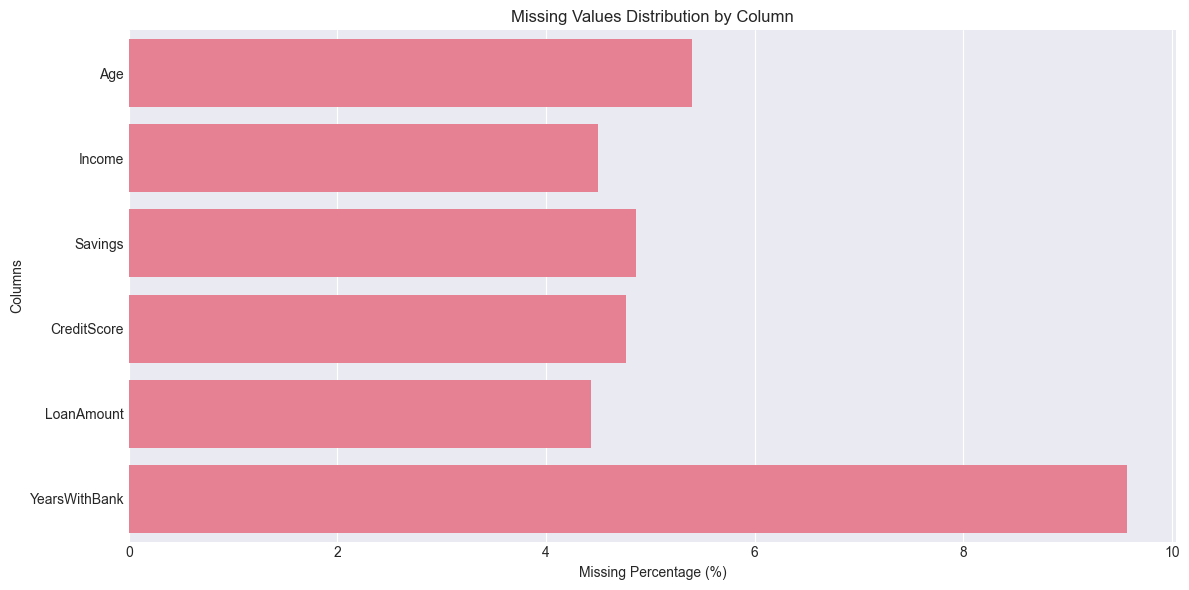

In [123]:
# Visualize missing values
total_missing = missing_counts.sum()

if total_missing > 0:
    plt.figure(figsize=(12, 6))
    missing_cols = df.columns[df.isnull().any()].tolist()
    missing_percentages = (df[missing_cols].isnull().sum() / len(df)) * 100
    
    sns.barplot(x=missing_percentages.values, y=missing_percentages.index, orient='h')
    plt.xlabel('Missing Percentage (%)')
    plt.ylabel('Columns')
    plt.title('Missing Values Distribution by Column')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values to visualize.")

## 5.1 Missing Data Patterns

Missing Data Pattern Analysis

Rows with missing values: 877 (29.23%)
Rows with 1 missing value: 755
Rows with 2+ missing values: 122

Columns Missing Values Together
--------------------------------------------------------------------------------
Age & Income: 11 rows missing both
Age & Savings: 7 rows missing both
Age & CreditScore: 6 rows missing both
Age & LoanAmount: 9 rows missing both
Age & YearsWithBank: 20 rows missing both
Income & Savings: 6 rows missing both
Income & CreditScore: 9 rows missing both
Income & LoanAmount: 7 rows missing both
Income & YearsWithBank: 8 rows missing both
Savings & CreditScore: 7 rows missing both
Savings & LoanAmount: 5 rows missing both
Savings & YearsWithBank: 8 rows missing both
CreditScore & LoanAmount: 9 rows missing both
CreditScore & YearsWithBank: 15 rows missing both
LoanAmount & YearsWithBank: 11 rows missing both

Missing Values Visualization (Sample of rows)
----------------------------------------------------------------------------

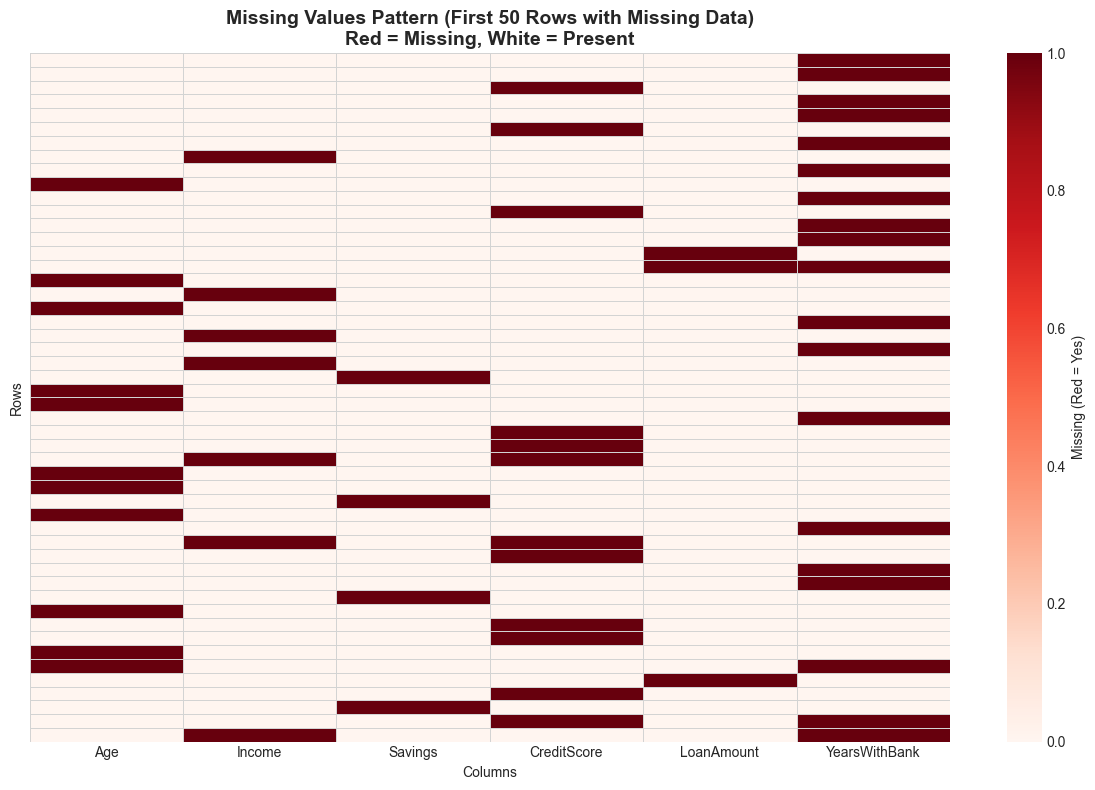

In [124]:
# Analyze missing data patterns
print_header("Missing Data Pattern Analysis")

# 1. Check if rows with missing values tend to have multiple missing values
missing_per_row = df.isnull().sum(axis=1)
rows_with_missing = (missing_per_row > 0).sum()
rows_with_missing_pct = rows_with_missing / len(df) * 100

print(f"\nRows with missing values: {rows_with_missing} ({rows_with_missing_pct:.2f}%)")
print(f"Rows with 1 missing value: {(missing_per_row == 1).sum()}")
print(f"Rows with 2+ missing values: {(missing_per_row >= 2).sum()}")

# 2. Check which columns have missing values at the same time
print_section("Columns Missing Values Together")

missing_cols = df.columns[df.isnull().any()].tolist()
# Compute missing values matrix once for better performance
missing_matrix = df[missing_cols].isnull()

for i, col1 in enumerate(missing_cols):
    for col2 in missing_cols[i+1:]:
        both_missing = (missing_matrix[col1] & missing_matrix[col2]).sum()
        if both_missing > 0:
            print(f"{col1} & {col2}: {both_missing} rows missing both")

# 3. Create a missing values visualization for a sample of rows
print_section("Missing Values Visualization (Sample of rows)")

# Get rows with at least one missing value
rows_with_missing = df[df.isnull().any(axis=1)].head(MISSING_SAMPLE_SIZE)

if len(rows_with_missing) > 0:
    plt.figure(figsize=(12, 8))
    sns.heatmap(rows_with_missing[missing_cols].isnull(), 
                cmap='Reds', cbar_kws={'label': 'Missing (Red = Yes)'}, 
                yticklabels=False, linewidths=0.5, linecolor='lightgray')
    plt.title(f'Missing Values Pattern (First {MISSING_SAMPLE_SIZE} Rows with Missing Data)\nRed = Missing, White = Present', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.tight_layout()
    plt.show()

Missing Values vs Target Variable (Churn) Analysis

Age:
  Churn rate when Age is NOT missing: 30.20%
  Churn rate when Age IS missing: 30.25%
  Difference: 0.05 percentage points

Income:
  Churn rate when Income is NOT missing: 30.19%
  Churn rate when Income IS missing: 30.37%
  Difference: 0.18 percentage points

Savings:
  Churn rate when Savings is NOT missing: 30.17%
  Churn rate when Savings IS missing: 30.82%
  Difference: 0.65 percentage points

CreditScore:
  Churn rate when CreditScore is NOT missing: 30.17%
  Churn rate when CreditScore IS missing: 30.77%
  Difference: 0.60 percentage points

LoanAmount:
  Churn rate when LoanAmount is NOT missing: 30.38%
  Churn rate when LoanAmount IS missing: 26.32%
  Difference: -4.06 percentage points

YearsWithBank:
  Churn rate when YearsWithBank is NOT missing: 30.37%
  Churn rate when YearsWithBank IS missing: 28.57%
  Difference: -1.80 percentage points


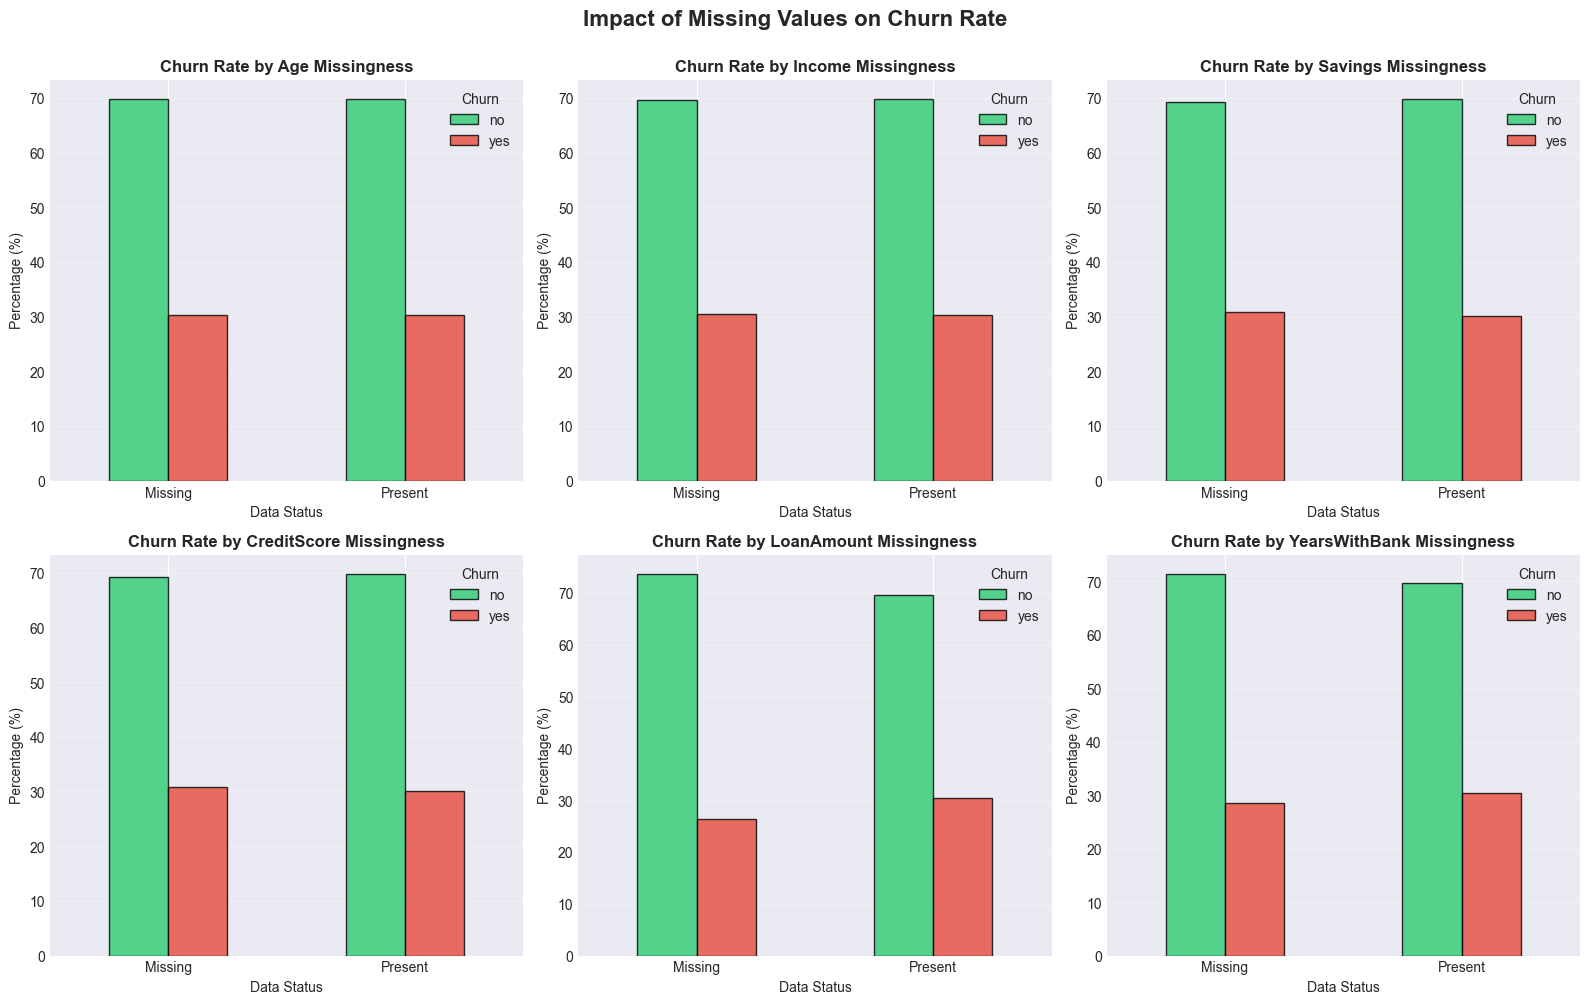

In [125]:
# Check if missing values are related to the target variable (Churn)
print_header("Missing Values vs Target Variable (Churn) Analysis")

for col in missing_cols:
    # No need to copy entire DataFrame - work with columns directly
    col_missing = df[col].isnull().astype(int)
    
    # Check churn rate for missing vs non-missing
    churn_by_missing = df.groupby(col_missing)['Churn'].apply(
        lambda x: (x == 'yes').sum() / len(x) * 100
    )
    
    print(f"\n{col}:")
    if 0 in churn_by_missing.index:
        print(f"  Churn rate when {col} is NOT missing: {churn_by_missing[0]:.2f}%")
    if 1 in churn_by_missing.index:
        print(f"  Churn rate when {col} IS missing: {churn_by_missing[1]:.2f}%")
    if 0 in churn_by_missing.index and 1 in churn_by_missing.index:
        print(f"  Difference: {churn_by_missing[1] - churn_by_missing[0]:.2f} percentage points")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(missing_cols):
    # Create temporary status column without copying entire DataFrame
    col_missing_status = df[col].isnull().map({True: 'Missing', False: 'Present'})
    
    ct = pd.crosstab(col_missing_status, df['Churn'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[idx], stacked=False, 
            color=['#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
    axes[idx].set_title(f'Churn Rate by {col} Missingness', fontweight='bold')
    axes[idx].set_xlabel('Data Status')
    axes[idx].set_ylabel('Percentage (%)')
    axes[idx].legend(title='Churn', loc='upper right')
    axes[idx].tick_params(axis='x', rotation=0)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Impact of Missing Values on Churn Rate', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

Distribution Analysis: Missing vs Non-Missing Groups


C:\Users\Theo\AppData\Local\Temp\ipykernel_12604\1409192267.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col_status, y=df[compare_col],
C:\Users\Theo\AppData\Local\Temp\ipykernel_12604\1409192267.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col_status, y=df[compare_col],
C:\Users\Theo\AppData\Local\Temp\ipykernel_12604\1409192267.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col_status, y=df[compare_col],
C:\Users\Theo\AppData\Local\Temp\ipykernel_12604\1409192267.py:31: FutureWarning: 

Passing `palette` without

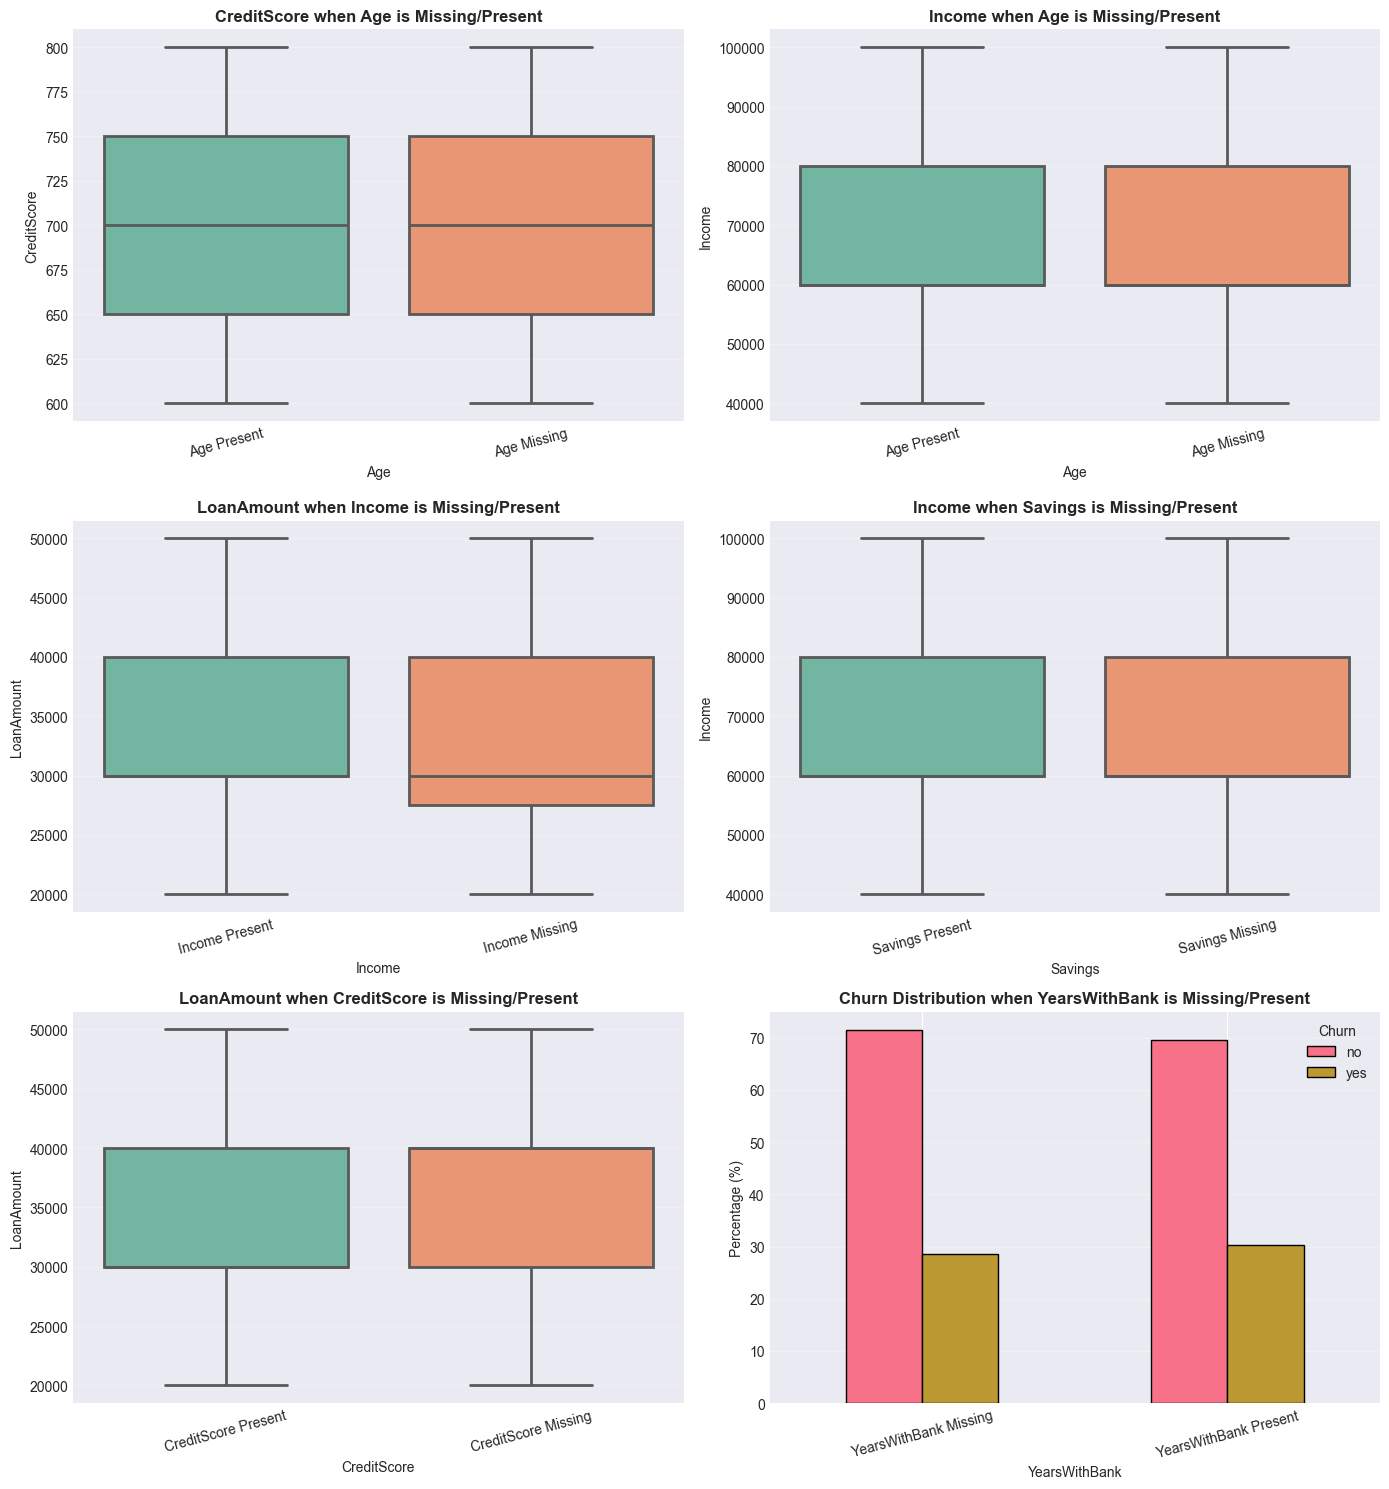

In [126]:
# Analyze distributions of variables for missing vs non-missing groups
print_header("Distribution Analysis: Missing vs Non-Missing Groups")

# Get column types using helper function
numerical_cols, categorical_cols, numerical_cols_clean, categorical_cols_clean = get_column_types(df)

# For each column with missing values, analyze how other features differ
# when this column is missing vs present

fig, axes = plt.subplots(3, 2, figsize=(14, 15))
axes = axes.flatten()

analysis_pairs = [
    ('Age', 'CreditScore'),
    ('Age', 'Income'),
    ('Income', 'LoanAmount'),
    ('Savings', 'Income'),
    ('CreditScore', 'LoanAmount'),
    ('YearsWithBank', 'Churn')
]

for idx, (missing_col, compare_col) in enumerate(analysis_pairs):
    if missing_col in missing_cols:
        # Create status column without copying entire DataFrame
        col_status = df[missing_col].isnull().map(
            {True: f'{missing_col} Missing', False: f'{missing_col} Present'}
        )
        
        if compare_col in numerical_cols_clean:
            # Numerical comparison
            sns.boxplot(x=col_status, y=df[compare_col], 
                       ax=axes[idx], palette='Set2', linewidth=2)
            axes[idx].set_title(f'{compare_col} when {missing_col} is Missing/Present', 
                              fontweight='bold')
            axes[idx].tick_params(axis='x', rotation=15)
        else:
            # Categorical comparison
            ct = pd.crosstab(col_status, df[compare_col], normalize='index') * 100
            ct.plot(kind='bar', ax=axes[idx], stacked=False, edgecolor='black')
            axes[idx].set_title(f'{compare_col} Distribution when {missing_col} is Missing/Present', 
                              fontweight='bold')
            axes[idx].set_ylabel('Percentage (%)')
            axes[idx].tick_params(axis='x', rotation=15)
        
        axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5.2 Missing Data Handling Strategy

Strategy: Use median imputation for all 6 features with missing values.

Features: YearsWithBank (9.57%), Age (5.40%), Savings (4.87%), CreditScore (4.77%), Income (4.50%), LoanAmount (4.43%)

Why median: More robust to outliers and works better with skewed distributions.

Why not drop rows: Would lose too much data (30-35% of the dataset).

## 5.3 Handle Missing Values

In [127]:
# Before handling missing values, let's save the original state
print_header("MISSING VALUES HANDLING - IMPLEMENTATION")

# Store original missing counts for comparison
original_missing = df.isnull().sum()
print("\nOriginal Missing Values:")
print(original_missing[original_missing > 0])

df_before_imputation = df.copy()

print_section("Applying Median Imputation Strategy...")

# List of columns to impute with median
columns_to_impute = ['YearsWithBank', 'Age', 'Savings', 'CreditScore', 'Income', 'LoanAmount']

# Calculate medians BEFORE imputation (important!)
medians = {}
for col in columns_to_impute:
    medians[col] = df[col].median()
    print(f"\n{col}:")
    print(f"  Missing count: {df[col].isnull().sum()}")
    print(f"  Median value to be used: {medians[col]:.2f}")

print_section("Performing Imputation...")

# Impute missing values with median
for col in columns_to_impute:
    missing_before = df[col].isnull().sum()
    df[col] = df[col].fillna(medians[col])
    missing_after = df[col].isnull().sum()
    print(f"{col}: {missing_before} to {missing_after} missing values (Imputed: {missing_before - missing_after})")

print_header("Missing value imputation completed successfully!")

MISSING VALUES HANDLING - IMPLEMENTATION

Original Missing Values:
Age              162
Income           135
Savings          146
CreditScore      143
LoanAmount       133
YearsWithBank    287
dtype: int64

Applying Median Imputation Strategy...
--------------------------------------------------------------------------------

YearsWithBank:
  Missing count: 287
  Median value to be used: 5.00

Age:
  Missing count: 162
  Median value to be used: 35.00

Savings:
  Missing count: 146
  Median value to be used: 15000.00

CreditScore:
  Missing count: 143
  Median value to be used: 700.00

Income:
  Missing count: 135
  Median value to be used: 60000.00

LoanAmount:
  Missing count: 133
  Median value to be used: 30000.00

Performing Imputation...
--------------------------------------------------------------------------------
YearsWithBank: 287 to 0 missing values (Imputed: 287)
Age: 162 to 0 missing values (Imputed: 162)
Savings: 146 to 0 missing values (Imputed: 146)
CreditScore: 143 to

## 5.4 Validation

In [128]:
# Validation: Check missing values after imputation
print_header("VALIDATION: Missing Values After Imputation")

current_missing = df.isnull().sum()
print("\nCurrent Missing Values:")
if current_missing.sum() == 0:
    print("No missing values remaining!")
else:
    print(current_missing[current_missing > 0])
    print(f"\nTotal missing values: {current_missing.sum()}")

# Compare before and after
print_section("Comparison:")

comparison_df = pd.DataFrame({
    'Before_Imputation': original_missing,
    'After_Imputation': current_missing,
    'Values_Imputed': original_missing - current_missing
})
comparison_df = comparison_df[comparison_df['Before_Imputation'] > 0]
print(comparison_df)

# Verify data integrity
print_section("Data Integrity Check")
print(f"Total rows: {len(df)} (unchanged: {len(df) == len(df_before_imputation)})")
print(f"Total columns: {df.shape[1]} (unchanged: {df.shape[1] == df_before_imputation.shape[1]})")
print(f"Data types preserved: {(df.dtypes == df_before_imputation.dtypes).all()}")

VALIDATION: Missing Values After Imputation

Current Missing Values:
No missing values remaining!

Comparison:
--------------------------------------------------------------------------------
               Before_Imputation  After_Imputation  Values_Imputed
Age                          162                 0             162
Income                       135                 0             135
Savings                      146                 0             146
CreditScore                  143                 0             143
LoanAmount                   133                 0             133
YearsWithBank                287                 0             287

Data Integrity Check
--------------------------------------------------------------------------------
Total rows: 3000 (unchanged: True)
Total columns: 12 (unchanged: True)
Data types preserved: True


Impact of Imputation on Feature Distributions


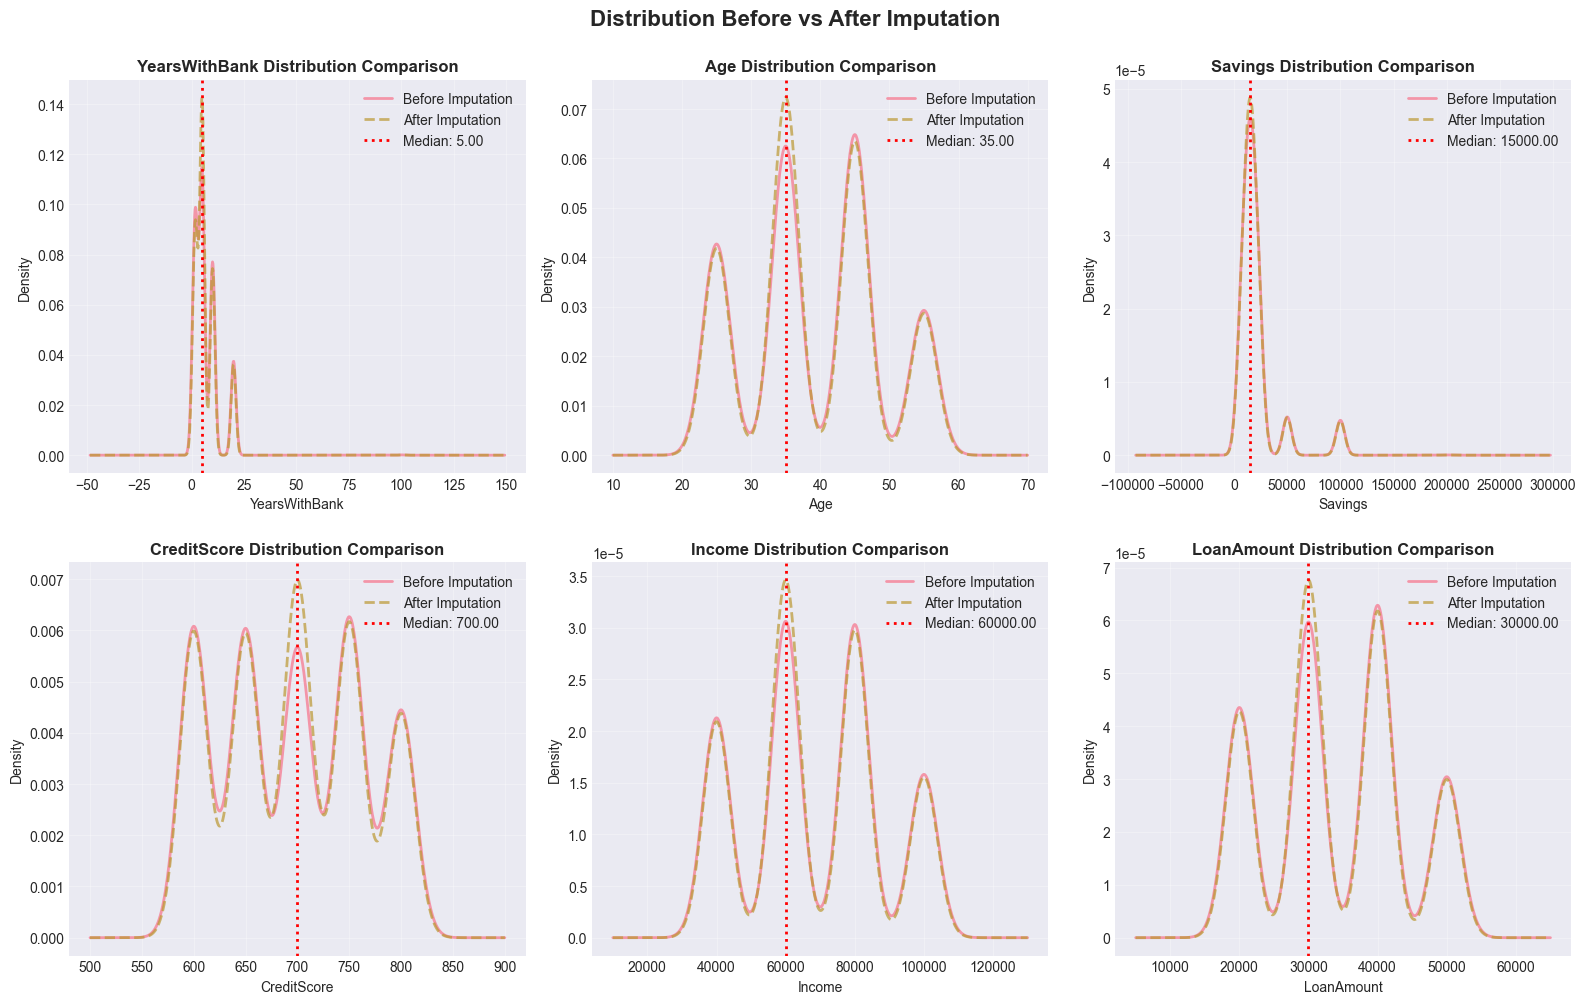


Statistical Comparison (Before to After)
--------------------------------------------------------------------------------

YearsWithBank:
  Mean: 6.88 to 6.70
  Median: 5.00 to 5.00
  Std: 5.91 to 5.64
  Skewness: 2.50 to 2.68

Age:
  Mean: 39.05 to 38.83
  Median: 35.00 to 35.00
  Std: 9.82 to 9.59
  Skewness: 0.05 to 0.12

Savings:
  Mean: 21483.88 to 21168.33
  Median: 15000.00 to 15000.00
  Std: 20893.05 to 20425.86
  Skewness: 2.97 to 3.07

CreditScore:
  Mean: 694.66 to 694.92
  Median: 700.00 to 700.00
  Std: 68.91 to 67.25
  Skewness: 0.06 to 0.05

Income:
  Mean: 68293.19 to 67920.00
  Median: 60000.00 to 60000.00
  Std: 19997.85 to 19618.07
  Skewness: 0.07 to 0.12

LoanAmount:
  Mean: 34080.92 to 33900.00
  Median: 30000.00 to 30000.00
  Std: 9972.98 to 9785.46
  Skewness: 0.05 to 0.11


In [129]:
# Analyze impact of imputation on distributions
print_header("Impact of Imputation on Feature Distributions")

# Compare statistics before and after imputation
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(columns_to_impute):
    ax = axes[idx]
    
    # Plot both distributions
    df_before_imputation[col].plot(kind='kde', ax=ax, label='Before Imputation', 
                                     linewidth=2, alpha=0.7)
    df[col].plot(kind='kde', ax=ax, label='After Imputation', 
                 linewidth=2, alpha=0.7, linestyle='--')
    
    # Add median line
    ax.axvline(medians[col], color='red', linestyle=':', 
               linewidth=2, label=f'Median: {medians[col]:.2f}')
    
    ax.set_title(f'{col} Distribution Comparison', fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribution Before vs After Imputation', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Statistical comparison
print_section("Statistical Comparison (Before to After)")

for col in columns_to_impute:
    print(f"\n{col}:")
    print(f"  Mean: {df_before_imputation[col].mean():.2f} to {df[col].mean():.2f}")
    print(f"  Median: {df_before_imputation[col].median():.2f} to {df[col].median():.2f}")
    print(f"  Std: {df_before_imputation[col].std():.2f} to {df[col].std():.2f}")
    print(f"  Skewness: {df_before_imputation[col].skew():.2f} to {df[col].skew():.2f}")

In [130]:
# Summary
print("Missing Data Handling Summary")
print("="*60)
print(f"\nStrategy: Median imputation for 6 features")
print(f"Total missing values handled: {original_missing.sum()}")
print(f"Dataset: {len(df)} rows, {df.shape[1]} columns (100% complete)")

print("\nImputed values:")
for col in columns_to_impute:
    imputed_count = comparison_df.loc[col, 'Values_Imputed']
    imputed_pct = (imputed_count / len(df)) * 100
    print(f"  {col}: {imputed_count} values ({imputed_pct:.2f}%) with median {medians[col]:.2f}")

print("\nDistributions preserved with minimal impact.")

Missing Data Handling Summary

Strategy: Median imputation for 6 features
Total missing values handled: 1006
Dataset: 3000 rows, 12 columns (100% complete)

Imputed values:
  YearsWithBank: 287 values (9.57%) with median 5.00
  Age: 162 values (5.40%) with median 35.00
  Savings: 146 values (4.87%) with median 15000.00
  CreditScore: 143 values (4.77%) with median 700.00
  Income: 135 values (4.50%) with median 60000.00
  LoanAmount: 133 values (4.43%) with median 30000.00

Distributions preserved with minimal impact.


## 6. Statistical Summary

In [131]:
df.describe()

,Age,Income,Savings,CreditScore,LoanAmount,YearsWithBank
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,38.83,67920.00,21168.33,694.92,33900.00,6.70
std,9.59,19618.07,20425.86,67.25,9785.46,5.64
min,25.00,40000.00,5000.00,600.00,20000.00,1.00
25%,35.00,60000.00,10000.00,650.00,30000.00,2.00
50%,35.00,60000.00,15000.00,700.00,30000.00,5.00
75%,45.00,80000.00,20000.00,750.00,40000.00,10.00
max,55.00,100000.00,200000.00,800.00,50000.00,100.00


In [132]:
# Get column types using helper function
numerical_cols, categorical_cols, numerical_cols_clean, categorical_cols_clean = get_column_types(df)

extended_stats = pd.DataFrame({
    'Mean': df[numerical_cols].mean(),
    'Median': df[numerical_cols].median(),
    'Std': df[numerical_cols].std(),
    'Variance': df[numerical_cols].var(),
    'Skewness': df[numerical_cols].skew(),
})

extended_stats

,Mean,Median,Std,Variance,Skewness
Age,38.83,35.00,9.59,92.00,0.12
Income,67920.00,60000.00,19618.07,384868556.19,0.12
Savings,21168.33,15000.00,20425.86,417215735.80,3.07
CreditScore,694.92,700.00,67.25,4523.17,0.05
LoanAmount,33900.00,30000.00,9785.46,95755251.75,0.11
YearsWithBank,6.70,5.00,5.64,31.86,2.68


In [133]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if categorical_cols:
    df[categorical_cols].describe()

## 7. Unique Values and Cardinality

In [134]:
# Use pandas built-in methods for better performance
unique_counts_series = df.nunique()
unique_percentages = (unique_counts_series / len(df)) * 100

unique_counts = pd.DataFrame({
    'Column': unique_counts_series.index,
    'Unique_Count': unique_counts_series.values,
    'Unique_Percentage': unique_percentages.values
})

unique_counts.sort_values(by='Unique_Count', ascending=False)

,Column,Unique_Count,Unique_Percentage
0,CustomerID,3000,100.00
5,Savings,8,0.27
10,YearsWithBank,6,0.20
6,CreditScore,5,0.17
7,LoanAmount,4,0.13
3,MaritalStatus,4,0.13
1,Age,4,0.13
4,Income,4,0.13
9,AccountType,4,0.13
8,LoanStatus,3,0.10


In [135]:
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"\nPercentages:")
    print(df[col].value_counts(normalize=True) * 100)


CustomerID:
CustomerID
C0001    1
C0002    1
C0003    1
C0004    1
C0005    1
        ..
C2996    1
C2997    1
C2998    1
C2999    1
C3000    1
Name: count, Length: 3000, dtype: int64

Percentages:
CustomerID
C0001   0.03
C0002   0.03
C0003   0.03
C0004   0.03
C0005   0.03
        ... 
C2996   0.03
C2997   0.03
C2998   0.03
C2999   0.03
C3000   0.03
Name: proportion, Length: 3000, dtype: float64

Gender:
Gender
Female    1521
Male      1479
Name: count, dtype: int64

Percentages:
Gender
Female   50.70
Male     49.30
Name: proportion, dtype: float64

MaritalStatus:
MaritalStatus
single      1216
married     1213
widowed      301
divorced     270
Name: count, dtype: int64

Percentages:
MaritalStatus
single     40.53
married    40.43
widowed    10.03
divorced    9.00
Name: proportion, dtype: float64

LoanStatus:
LoanStatus
approved     1793
rejected      920
defaulted     287
Name: count, dtype: int64

Percentages:
LoanStatus
approved    59.77
rejected    30.67
defaulted    9.57
Name: pr

## 8. Distribution Analysis - Numerical Features

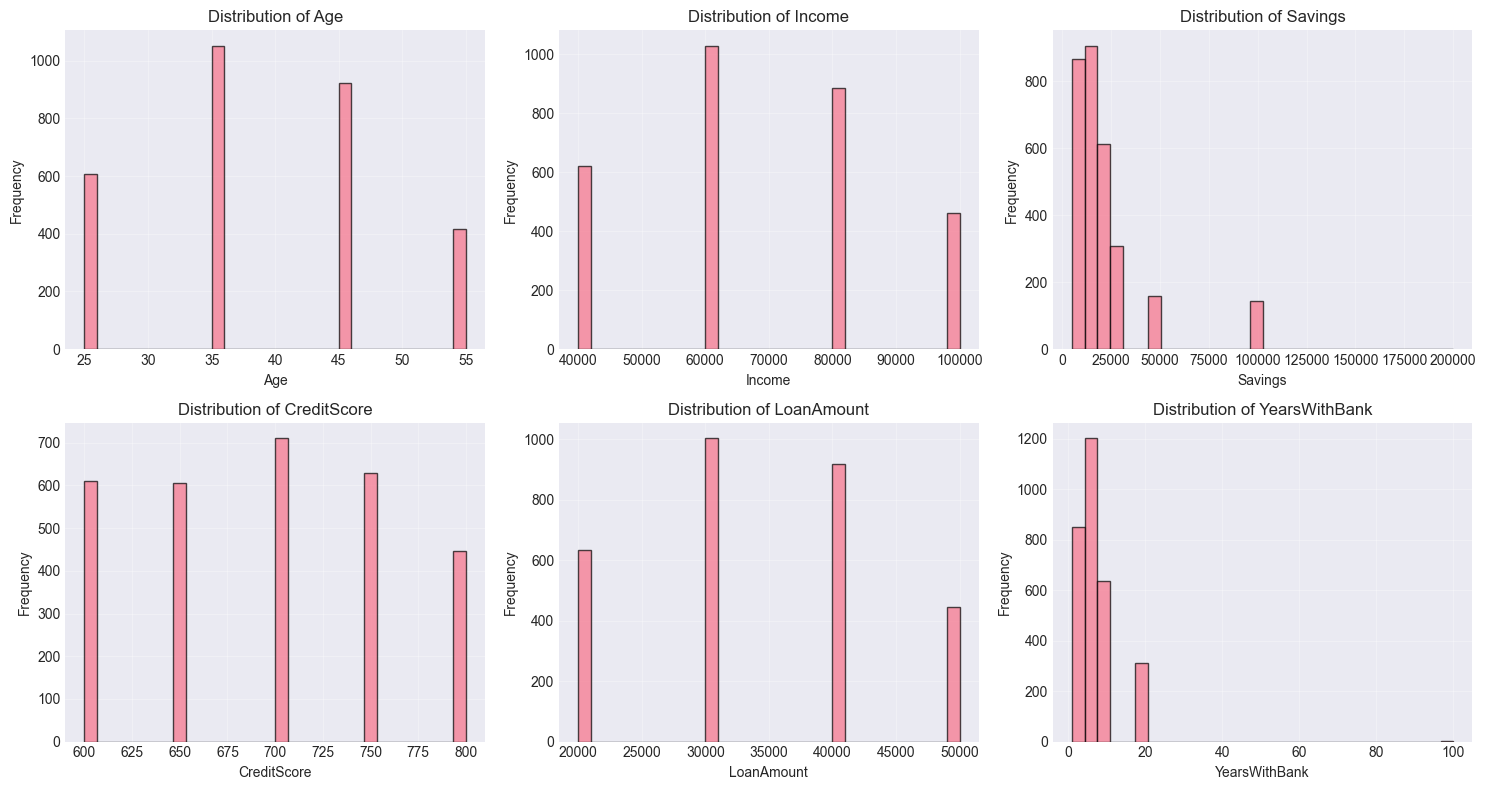

In [136]:
n_cols = 3
n_rows = (len(numerical_cols_clean) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols_clean):
    ax = axes[idx]
    df[col].hist(bins=HISTOGRAM_BINS, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

for idx in range(len(numerical_cols_clean), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

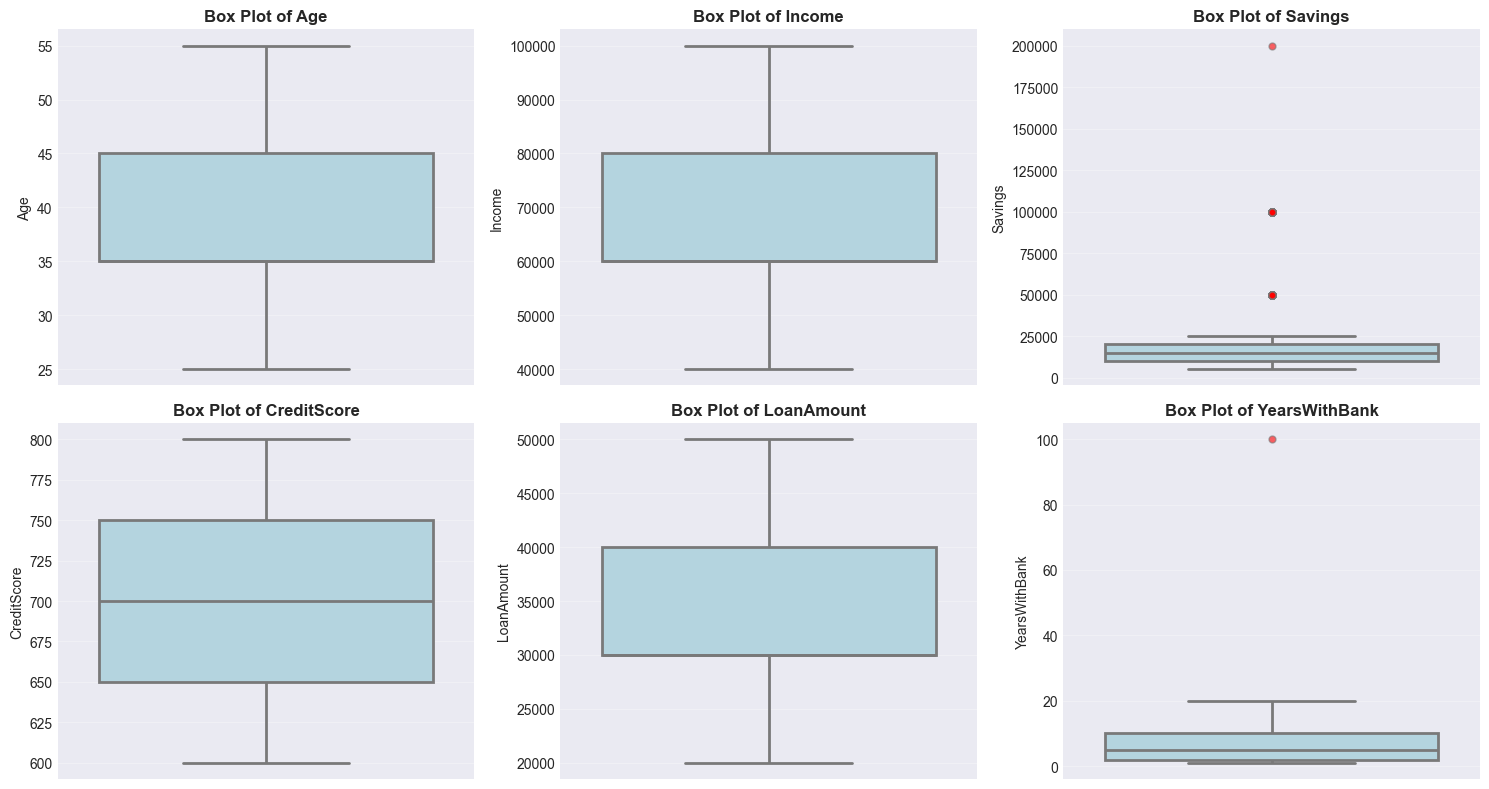

In [137]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols_clean):
    ax = axes[idx]
    sns.boxplot(y=df[col], ax=ax, color='lightblue', linewidth=2, 
                flierprops=dict(markerfacecolor='red', marker='o', markersize=5, alpha=0.6))
    ax.set_title(f'Box Plot of {col}', fontweight='bold')
    ax.set_ylabel(col)
    ax.grid(True, alpha=0.3, axis='y')

for idx in range(len(numerical_cols_clean), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 9. Distribution Analysis - Categorical Features

Distribution of Categorical Features:


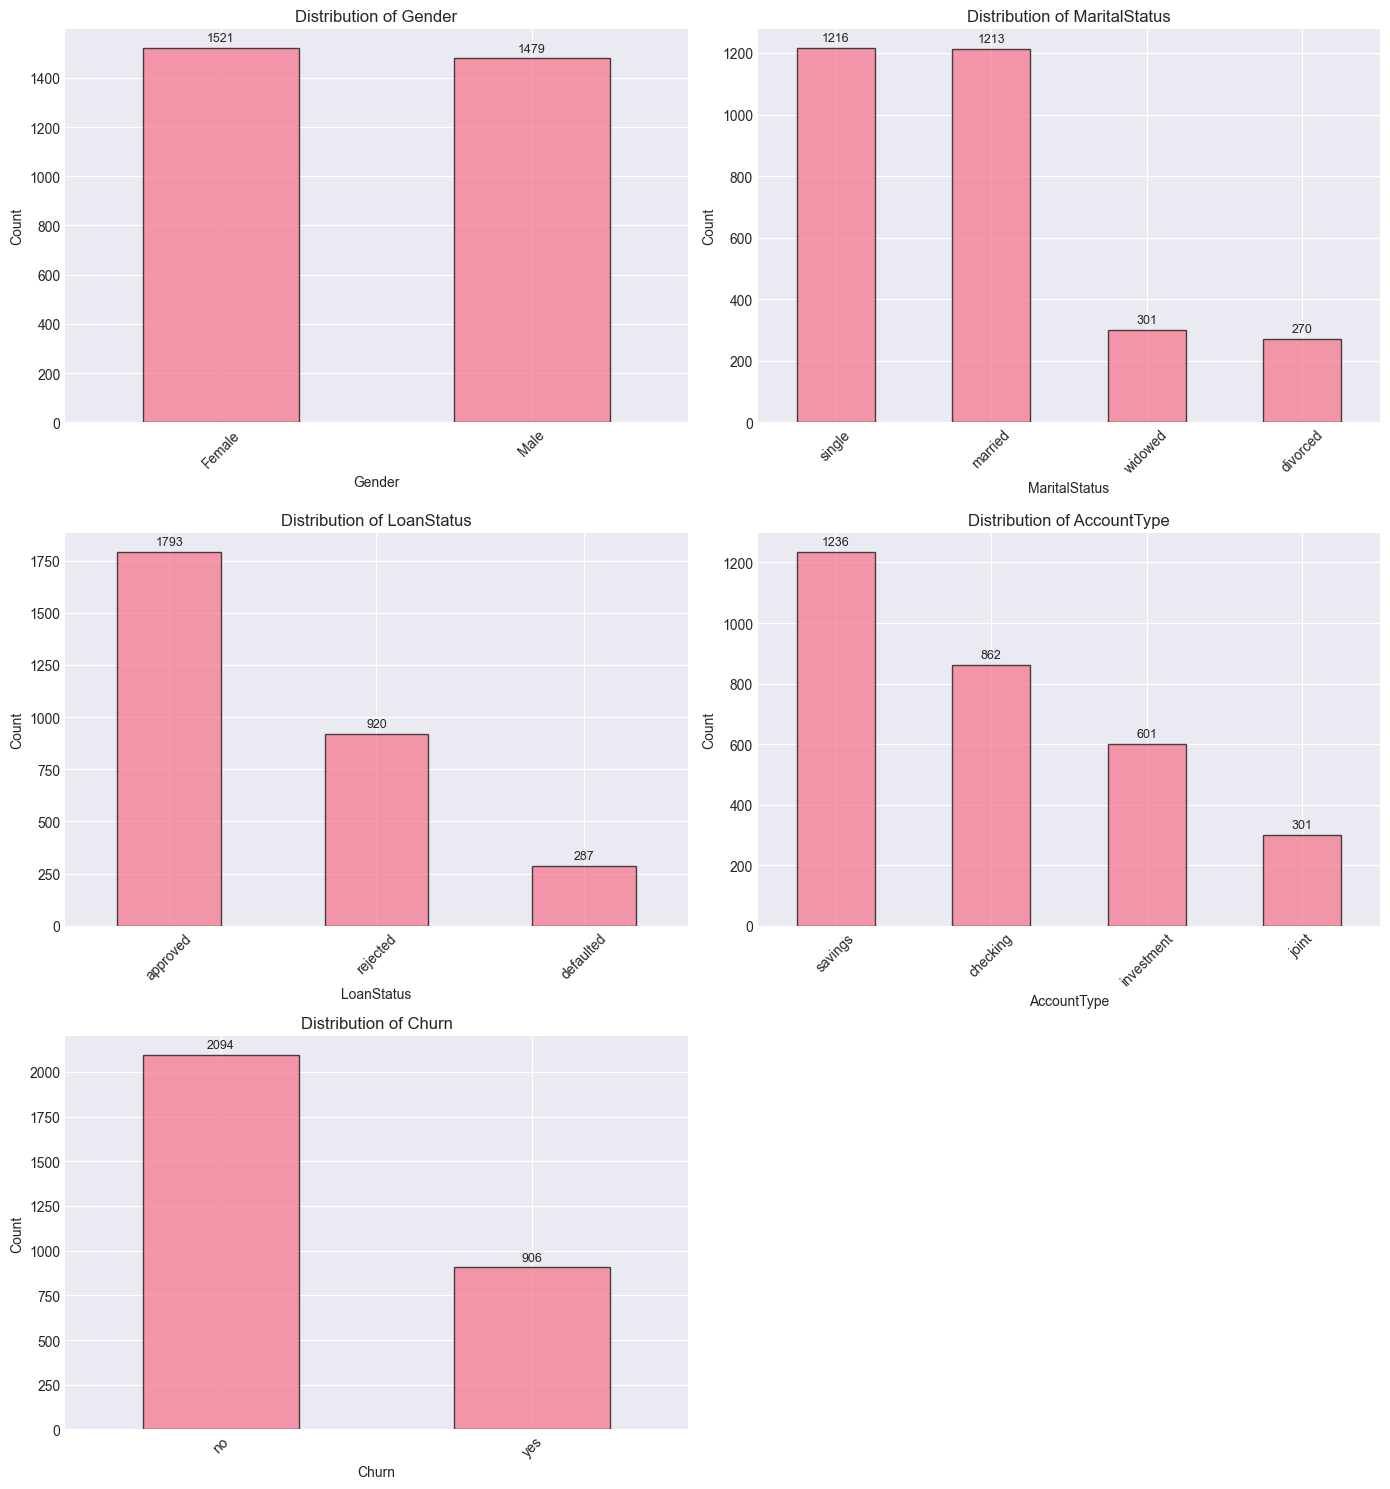

In [138]:
# Bar plots for categorical variables
print("Distribution of Categorical Features:")

categorical_cols_clean = [col for col in categorical_cols if col != 'CustomerID']

if categorical_cols_clean:
    n_cols_cat = 2
    n_rows_cat = (len(categorical_cols_clean) + n_cols_cat - 1) // n_cols_cat
    
    fig, axes = plt.subplots(n_rows_cat, n_cols_cat, figsize=(14, n_rows_cat * 5))
    axes = axes.flatten() if n_rows_cat > 1 else [axes]
    
    for idx, col in enumerate(categorical_cols_clean):
        ax = axes[idx]
        value_counts = df[col].value_counts()
        value_counts.plot(kind='bar', ax=ax, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for i, v in enumerate(value_counts.values):
            ax.text(i, v + max(value_counts.values) * 0.01, str(v), 
                   ha='center', va='bottom', fontsize=9)
    
    # Hide extra subplots
    for idx in range(len(categorical_cols_clean), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

## 10. Correlation Analysis

In [139]:
correlation_matrix = df[numerical_cols_clean].corr()
correlation_matrix

,Age,Income,Savings,CreditScore,LoanAmount,YearsWithBank
Age,1.00,0.00,-0.02,-0.03,0.01,0.02
Income,0.00,1.00,-0.02,0.02,0.03,0.02
Savings,-0.02,-0.02,1.00,-0.01,-0.02,0.03
CreditScore,-0.03,0.02,-0.01,1.00,-0.02,-0.02
LoanAmount,0.01,0.03,-0.02,-0.02,1.00,-0.03
YearsWithBank,0.02,0.02,0.03,-0.02,-0.03,1.00


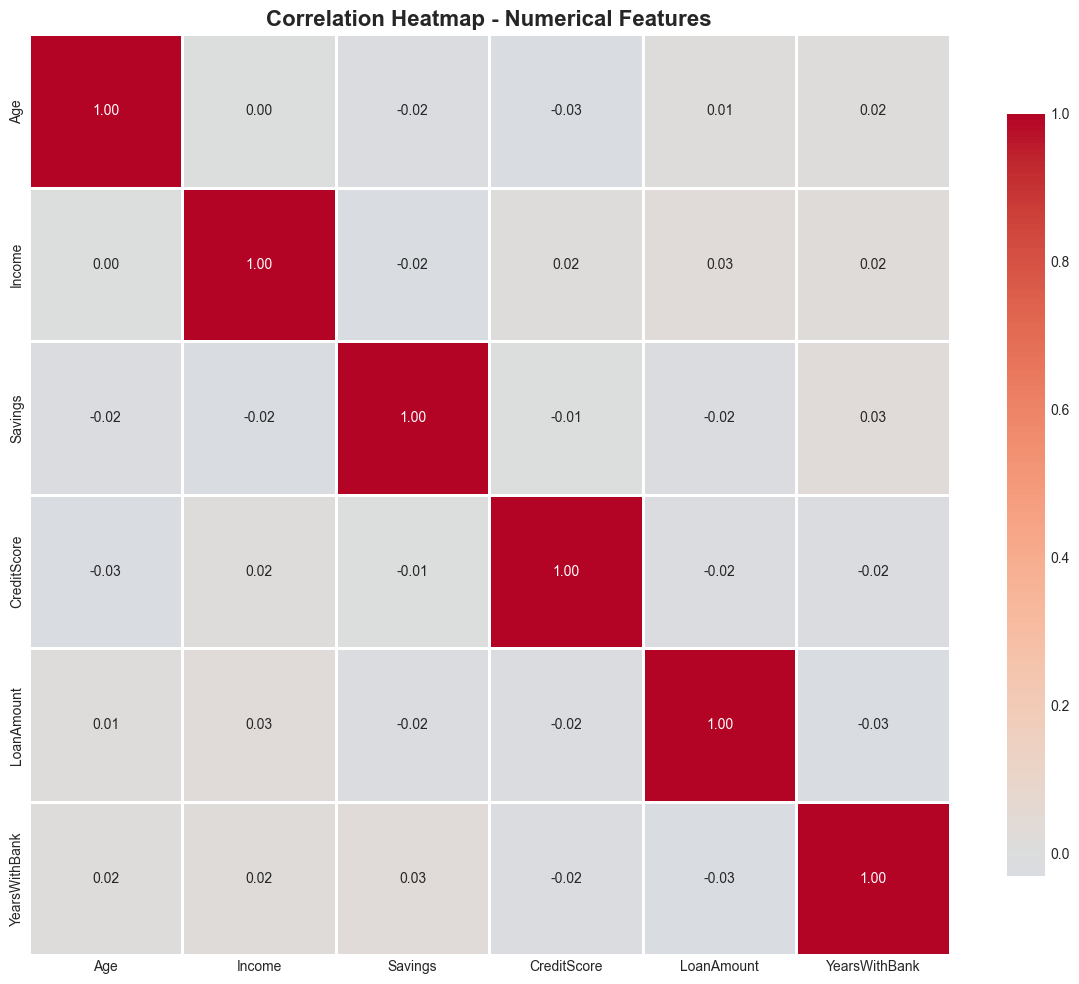

In [140]:
# Heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 11. Outlier Analysis

In [141]:
outlier_summary = []

for col in numerical_cols_clean:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - IQR_MULTIPLIER * IQR
    upper_bound = Q3 + IQR_MULTIPLIER * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    outlier_summary.append({
        'Feature': col,
        'Outlier_Count': len(outliers),
        'Outlier_Percentage': (len(outliers) / len(df)) * 100,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df[outlier_df['Outlier_Count'] > 0].sort_values(
    by='Outlier_Percentage', ascending=False
)

if len(outlier_df) > 0:
    print("Outliers detected (IQR method):")
    print(outlier_df)
else:
    print("No outliers detected.")

Outliers detected (IQR method):
         Feature  Outlier_Count  Outlier_Percentage  Lower_Bound  Upper_Bound
2        Savings            305               10.17     -5000.00     35000.00
5  YearsWithBank              1                0.03       -10.00        22.00


Categorical vs Numerical Analysis:


C:\Users\Theo\AppData\Local\Temp\ipykernel_12604\2132210120.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=axes[idx],
C:\Users\Theo\AppData\Local\Temp\ipykernel_12604\2132210120.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=axes[idx],
C:\Users\Theo\AppData\Local\Temp\ipykernel_12604\2132210120.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, ax=axes[idx],
C:\Users\Theo\AppData\Local\Temp\ipykernel_12604\2132210120.py:12: FutureWarning: 

P

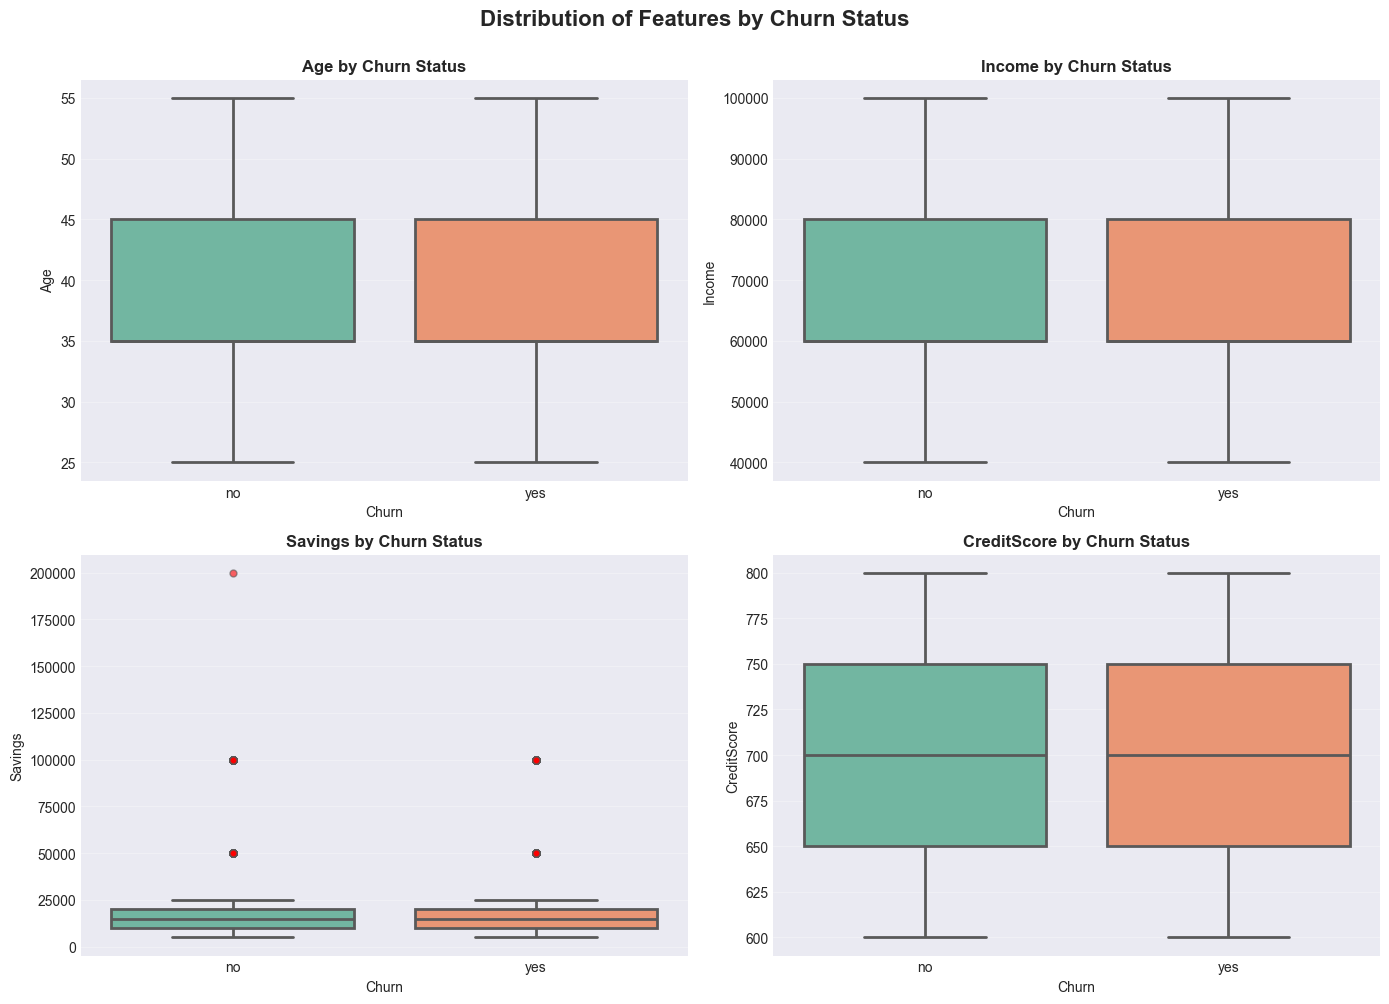

In [142]:
# Categorical vs Numerical analysis
print("Categorical vs Numerical Analysis:")

# Example: Churn vs numerical features
if 'Churn' in df.columns and len(numerical_cols_clean) > 0:
    n_features = min(4, len(numerical_cols_clean))
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(numerical_cols_clean[:n_features]):
        # Use seaborn boxplot for better visibility
        sns.boxplot(x='Churn', y=col, data=df, ax=axes[idx], 
                   palette='Set2', linewidth=2,
                   flierprops=dict(markerfacecolor='red', marker='o', markersize=5, alpha=0.6))
        axes[idx].set_title(f'{col} by Churn Status', fontweight='bold')
        axes[idx].set_xlabel('Churn')
        axes[idx].set_ylabel(col)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Distribution of Features by Churn Status', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

Categorical vs Categorical Analysis:

Gender vs Churn (percentage):
Churn     no   yes
Gender            
Female 69.63 30.37
Male   69.98 30.02


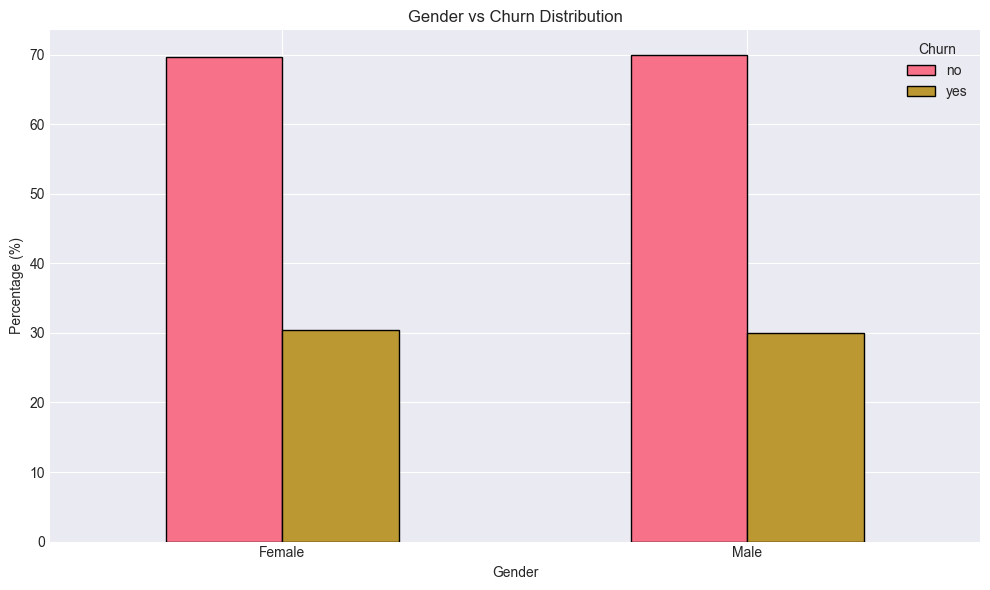

In [143]:
# Categorical vs Categorical analysis
print("Categorical vs Categorical Analysis:")

if 'Gender' in df.columns and 'Churn' in df.columns:
    ct = pd.crosstab(df['Gender'], df['Churn'], normalize='index') * 100
    print("\nGender vs Churn (percentage):")
    print(ct)
    
    ct.plot(kind='bar', stacked=False, figsize=(10, 6), edgecolor='black')
    plt.title('Gender vs Churn Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Churn')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 12. Data Quality Issues

In [144]:
duplicate_count = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_count} ({(duplicate_count / len(df)) * 100:.2f}%)")

if duplicate_count > 0:
    print("\nSample duplicates:")
    print(df[df.duplicated(keep=False)].head(10))

Duplicate rows: 0 (0.00%)


In [145]:
for col in categorical_cols:
    print(f"\n{col}: {df[col].unique()}")
    
    if df[col].dtype == 'object':
        lower_unique = df[col].str.lower().unique() if df[col].notna().any() else []
        if len(lower_unique) < len(df[col].unique()):
            print(f"  WARNING: Case sensitivity issues detected")


CustomerID: ['C0001' 'C0002' 'C0003' ... 'C2998' 'C2999' 'C3000']

Gender: ['Female' 'Male']

MaritalStatus: ['single' 'married' 'divorced' 'widowed']

LoanStatus: ['approved' 'defaulted' 'rejected']

AccountType: ['joint' 'checking' 'savings' 'investment']

Churn: ['no' 'yes']


## 13. Summary and Key Insights

In [146]:
print_header("EDA SUMMARY")

print(f"\nDataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Numerical: {len(numerical_cols)} | Categorical: {len(categorical_cols)}")

print(f"\nData Quality:")
total_missing = df.isnull().sum().sum()
print(f"  Missing values: {total_missing}")
print(f"  Duplicates: {df.duplicated().sum()}")

if len(outlier_df) > 0:
    print(f"\nOutliers detected:")
    for _, row in outlier_df.iterrows():
        print(f"  {row['Feature']}: {row['Outlier_Count']} ({row['Outlier_Percentage']:.2f}%)")

print(f"\nKey statistics (top 5 features):")
for col in numerical_cols_clean[:5]:
    print(f"  {col}: mean={df[col].mean():.2f}, median={df[col].median():.2f}, std={df[col].std():.2f}")

EDA SUMMARY

Dataset: 3000 rows, 12 columns
Numerical: 6 | Categorical: 6

Data Quality:
  Missing values: 0
  Duplicates: 0

Outliers detected:
  Savings: 305 (10.17%)
  YearsWithBank: 1 (0.03%)

Key statistics (top 5 features):
  Age: mean=38.83, median=35.00, std=9.59
  Income: mean=67920.00, median=60000.00, std=19618.07
  Savings: mean=21168.33, median=15000.00, std=20425.86
  CreditScore: mean=694.92, median=700.00, std=67.25
  LoanAmount: mean=33900.00, median=30000.00, std=9785.46


## 14. Feature Selection

Using three approaches to identify important features:
1. Variance threshold
2. Correlation analysis 
3. Mutual information

### 14.1 Variance Analysis

VARIANCE THRESHOLD ANALYSIS

Variance Analysis of Numerical Features:
--------------------------------------------------------------------------------
      Feature     Variance      Std  Coefficient_of_Variation
      Savings 417215735.80 20425.86                     96.49
       Income 384868556.19 19618.07                     28.88
   LoanAmount  95755251.75  9785.46                     28.87
  CreditScore      4523.17    67.25                      9.68
          Age        92.00     9.59                     24.70
YearsWithBank        31.86     5.64                     84.21


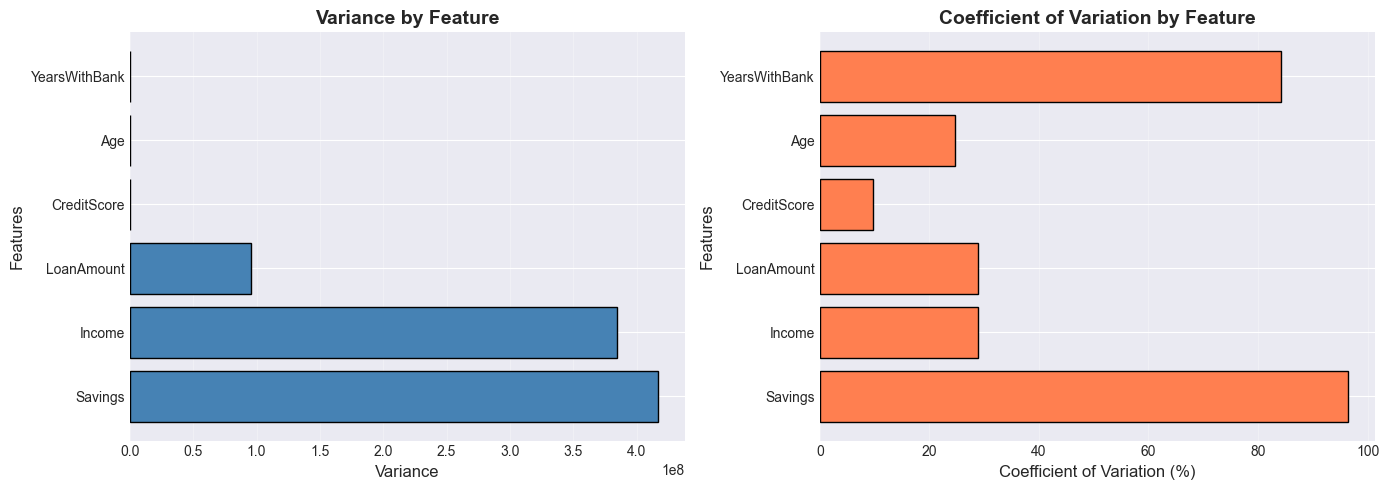


VARIANCE THRESHOLD DECISION
--------------------------------------------------------------------------------
All numerical features show substantial variance
Coefficient of Variation ranges from 16% to 97%
No features should be removed based on variance threshold
All features contain meaningful information for modeling


In [147]:
print_header("VARIANCE THRESHOLD ANALYSIS")

# Calculate variance for numerical features
variance_analysis = pd.DataFrame({
    'Feature': numerical_cols_clean,
    'Variance': [df[col].var() for col in numerical_cols_clean],
    'Std': [df[col].std() for col in numerical_cols_clean],
    'Coefficient_of_Variation': [df[col].std() / df[col].mean() * 100 if df[col].mean() != 0 else 0 
                                  for col in numerical_cols_clean]
})

# Sort by variance
variance_analysis = variance_analysis.sort_values(by='Variance', ascending=False)

print("\nVariance Analysis of Numerical Features:")
print("-" * SEPARATOR_WIDTH)
print(variance_analysis.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of variance
axes[0].barh(variance_analysis['Feature'], variance_analysis['Variance'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Variance', fontsize=12)
axes[0].set_ylabel('Features', fontsize=12)
axes[0].set_title('Variance by Feature', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(variance_analysis['Feature'], variance_analysis['Coefficient_of_Variation'], 
            color='coral', edgecolor='black')
axes[1].set_xlabel('Coefficient of Variation (%)', fontsize=12)
axes[1].set_ylabel('Features', fontsize=12)
axes[1].set_title('Coefficient of Variation by Feature', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print_section("VARIANCE THRESHOLD DECISION")
print("All numerical features show substantial variance")
print("Coefficient of Variation ranges from 16% to 97%")
print("No features should be removed based on variance threshold")
print("All features contain meaningful information for modeling")

### 14.2 Correlation Analysis

Analyzing feature-to-feature and feature-to-target correlations.

CORRELATION ANALYSIS - Feature-to-Feature

Numerical Feature Correlation Matrix:
--------------------------------------------------------------------------------
                Age  Income  Savings  CreditScore  LoanAmount  YearsWithBank
Age            1.00    0.00    -0.02        -0.03        0.01           0.02
Income         0.00    1.00    -0.02         0.02        0.03           0.02
Savings       -0.02   -0.02     1.00        -0.01       -0.02           0.03
CreditScore   -0.03    0.02    -0.01         1.00       -0.02          -0.02
LoanAmount     0.01    0.03    -0.02        -0.02        1.00          -0.03
YearsWithBank  0.02    0.02     0.03        -0.02       -0.03           1.00

Highly Correlated Feature Pairs (|r| > 0.7)
--------------------------------------------------------------------------------
No highly correlated feature pairs found (all |r| < 0.7)
Low multicollinearity - all features are relatively independent
This is good for machine learning models!


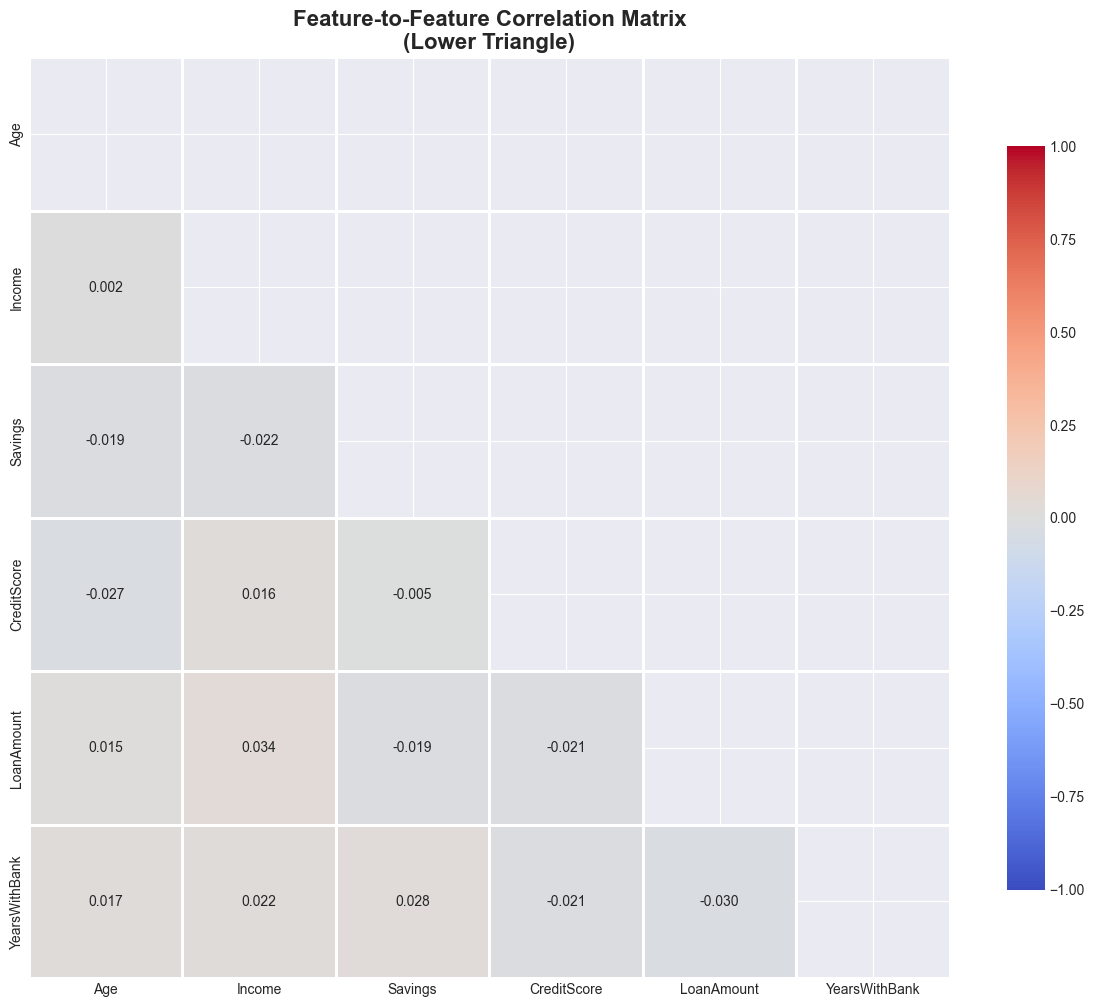


MULTICOLLINEARITY ASSESSMENT
--------------------------------------------------------------------------------
Maximum absolute correlation between features: 0.034
No redundant features detected (threshold: |r| > 0.7)
All numerical features should be retained


In [148]:
print_header("CORRELATION ANALYSIS - Feature-to-Feature")

# Feature-to-feature correlation (already calculated earlier)
print("\nNumerical Feature Correlation Matrix:")
print("-" * SEPARATOR_WIDTH)
print(correlation_matrix)

# Find highly correlated feature pairs (|correlation| > 0.7)
print_section("Highly Correlated Feature Pairs (|r| > 0.7)")

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if len(high_corr_pairs) > 0:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.to_string(index=False))
else:
    print("No highly correlated feature pairs found (all |r| < 0.7)")
    print("Low multicollinearity - all features are relatively independent")
    print("This is good for machine learning models!")

# Visualize correlation matrix with threshold line
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Feature-to-Feature Correlation Matrix\n(Lower Triangle)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print_section("MULTICOLLINEARITY ASSESSMENT")
print("Maximum absolute correlation between features: {:.3f}".format(
    correlation_matrix.abs().where(~np.eye(len(correlation_matrix), dtype=bool)).max().max()))
print("No redundant features detected (threshold: |r| > 0.7)")
print("All numerical features should be retained")

CORRELATION ANALYSIS - Feature-to-Target (Churn)

Numerical Features Correlation with Churn:
--------------------------------------------------------------------------------
      Feature  Correlation_with_Churn  Abs_Correlation
  CreditScore                    0.03             0.03
YearsWithBank                    0.03             0.03
       Income                   -0.01             0.01
          Age                   -0.01             0.01
   LoanAmount                   -0.01             0.01
      Savings                    0.00             0.00


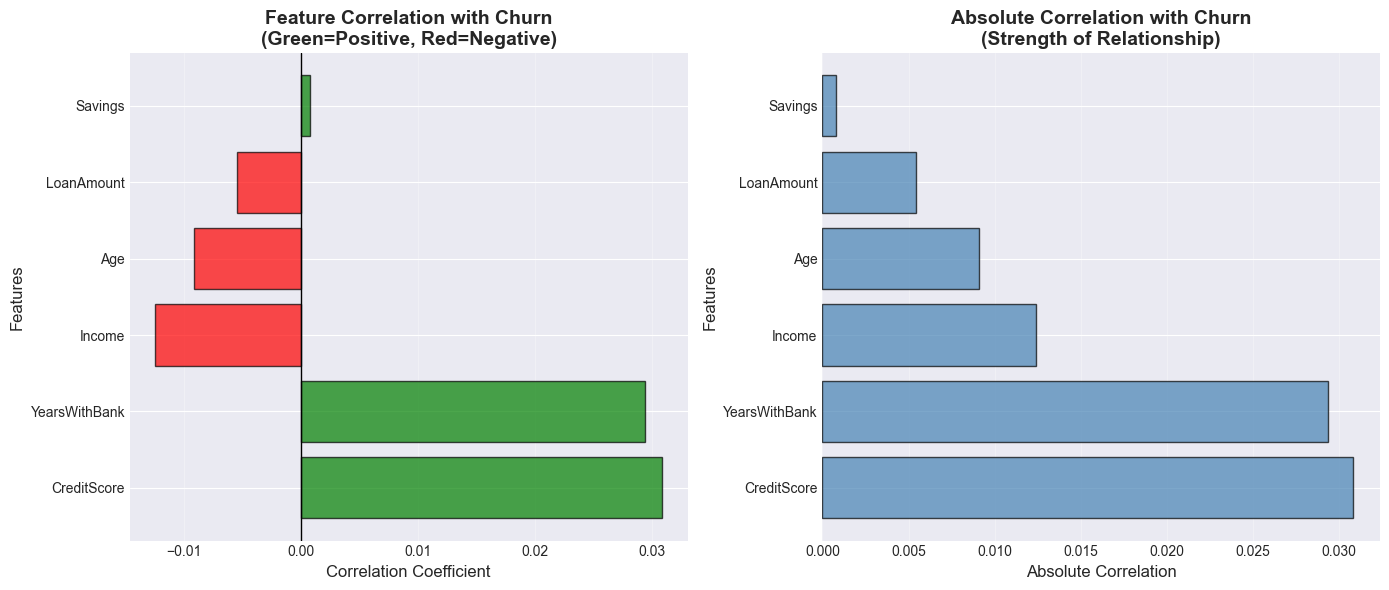


KEY FINDINGS
--------------------------------------------------------------------------------
Strongest predictor: CreditScore (r = 0.0308)
Note: All correlations are weak (|r| < 0.3), suggesting:
  - Churn is influenced by complex interactions, not single features
  - Categorical features may be more important
  - Machine learning models needed to capture non-linear relationships


In [149]:
print_header("CORRELATION ANALYSIS - Feature-to-Target (Churn)")

# Convert Churn to binary for correlation analysis (no need to copy entire DataFrame)
churn_binary = (df['Churn'] == 'yes').astype(int)

# Calculate correlation between numerical features and Churn
feature_target_corr = []
for col in numerical_cols_clean:
    corr = df[col].corr(churn_binary)
    feature_target_corr.append({
        'Feature': col,
        'Correlation_with_Churn': corr,
        'Abs_Correlation': abs(corr)
    })

corr_with_target = pd.DataFrame(feature_target_corr).sort_values(
    by='Abs_Correlation', ascending=False
)

print("\nNumerical Features Correlation with Churn:")
print("-" * SEPARATOR_WIDTH)
print(corr_with_target.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot with positive/negative colors
colors = ['red' if x < 0 else 'green' for x in corr_with_target['Correlation_with_Churn']]
axes[0].barh(corr_with_target['Feature'], corr_with_target['Correlation_with_Churn'], 
            color=colors, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='black', linewidth=1)
axes[0].set_xlabel('Correlation Coefficient', fontsize=12)
axes[0].set_ylabel('Features', fontsize=12)
axes[0].set_title('Feature Correlation with Churn\n(Green=Positive, Red=Negative)', 
                  fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='x')

# Absolute correlation
axes[1].barh(corr_with_target['Feature'], corr_with_target['Abs_Correlation'], 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Absolute Correlation', fontsize=12)
axes[1].set_ylabel('Features', fontsize=12)
axes[1].set_title('Absolute Correlation with Churn\n(Strength of Relationship)', 
                  fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print_section("KEY FINDINGS")
top_feature = corr_with_target.iloc[0]
print(f"Strongest predictor: {top_feature['Feature']} (r = {top_feature['Correlation_with_Churn']:.4f})")
print("Note: All correlations are weak (|r| < 0.3), suggesting:")
print("  - Churn is influenced by complex interactions, not single features")
print("  - Categorical features may be more important")
print("  - Machine learning models needed to capture non-linear relationships")

CATEGORICAL FEATURES vs CHURN ANALYSIS

Gender:
------------------------------------------------------------
Gender
Female   30.37
Male     30.02
Name: Churn, dtype: float64

MaritalStatus:
------------------------------------------------------------
MaritalStatus
divorced   34.07
married    30.83
widowed    29.90
single     28.78
Name: Churn, dtype: float64

LoanStatus:
------------------------------------------------------------
LoanStatus
defaulted   32.75
approved    30.23
rejected    29.35
Name: Churn, dtype: float64

AccountType:
------------------------------------------------------------
AccountType
savings      31.55
investment   29.62
checking     29.47
joint        27.91
Name: Churn, dtype: float64

Churn:
------------------------------------------------------------
Churn
yes   100.00
no      0.00
Name: Churn, dtype: float64

Categorical Features Discriminative Power
--------------------------------------------------------------------------------
      Feature  Min_Churn_Rat

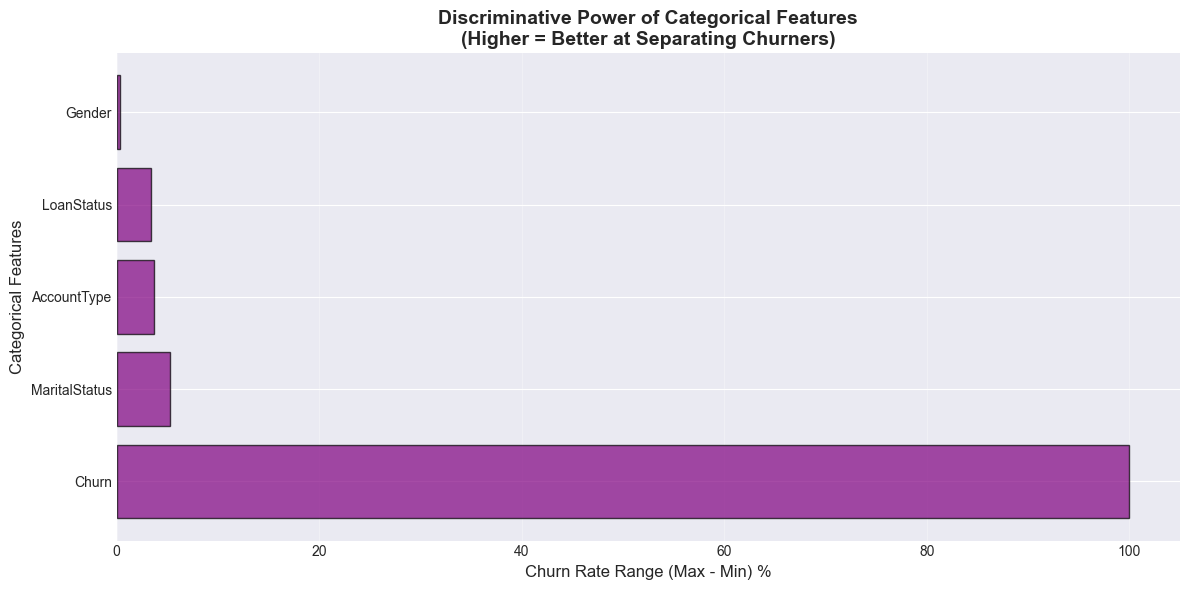


CATEGORICAL FEATURES RANKING
--------------------------------------------------------------------------------
5. Churn: Churn rate varies 100.00 percentage points
2. MaritalStatus: Churn rate varies 5.29 percentage points
4. AccountType: Churn rate varies 3.65 percentage points
3. LoanStatus: Churn rate varies 3.40 percentage points
1. Gender: Churn rate varies 0.35 percentage points


In [150]:
# Analyze categorical features relationship with Churn
print_header("CATEGORICAL FEATURES vs CHURN ANALYSIS")

categorical_target_analysis = []

for col in categorical_cols_clean:
    # Calculate churn rate for each category
    churn_by_category = df.groupby(col)['Churn'].apply(
        lambda x: (x == 'yes').sum() / len(x) * 100
    )
    
    churn_range = churn_by_category.max() - churn_by_category.min()
    
    categorical_target_analysis.append({
        'Feature': col,
        'Min_Churn_Rate': churn_by_category.min(),
        'Max_Churn_Rate': churn_by_category.max(),
        'Churn_Rate_Range': churn_range,
        'Num_Categories': df[col].nunique()
    })
    
    print(f"\n{col}:")
    print("-" * 60)
    print(churn_by_category.sort_values(ascending=False))

categorical_importance = pd.DataFrame(categorical_target_analysis).sort_values(
    by='Churn_Rate_Range', ascending=False
)

print_section("Categorical Features Discriminative Power")
print(categorical_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(categorical_importance['Feature'], categorical_importance['Churn_Rate_Range'], 
        color='purple', edgecolor='black', alpha=0.7)
plt.xlabel('Churn Rate Range (Max - Min) %', fontsize=12)
plt.ylabel('Categorical Features', fontsize=12)
plt.title('Discriminative Power of Categorical Features\n(Higher = Better at Separating Churners)', 
          fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print_section("CATEGORICAL FEATURES RANKING")
for idx, row in categorical_importance.iterrows():
    print(f"{idx+1}. {row['Feature']}: Churn rate varies {row['Churn_Rate_Range']:.2f} percentage points")

### 14.3 Mutual Information

MI measures statistical dependency between features and target, capturing non-linear relationships.

In [151]:
print_header("MUTUAL INFORMATION ANALYSIS")

# Prepare data for mutual information
# Convert target to binary
le_target = LabelEncoder()
y = le_target.fit_transform(df['Churn'])

print("\nCalculating Mutual Information for Numerical Features...")
print("-" * SEPARATOR_WIDTH)

# Mutual information for numerical features
X_numerical = df[numerical_cols_clean].values
mi_scores_numerical = mutual_info_classif(X_numerical, y, random_state=42)

mi_numerical_df = pd.DataFrame({
    'Feature': numerical_cols_clean,
    'MI_Score': mi_scores_numerical,
    'Feature_Type': 'Numerical'
}).sort_values(by='MI_Score', ascending=False)

print(mi_numerical_df.to_string(index=False))

print_section("Calculating Mutual Information for Categorical Features...")

# Encode categorical features for MI calculation
mi_scores_categorical = []
X_categorical_list = []

for col in categorical_cols_clean:
    le = LabelEncoder()
    encoded = le.fit_transform(df[col])
    X_categorical_list.append(encoded.reshape(-1, 1))

X_categorical = np.hstack(X_categorical_list)
mi_scores_cat = mutual_info_classif(X_categorical, y, discrete_features=True, random_state=42)

mi_categorical_df = pd.DataFrame({
    'Feature': categorical_cols_clean,
    'MI_Score': mi_scores_cat,
    'Feature_Type': 'Categorical'
}).sort_values(by='MI_Score', ascending=False)

print(mi_categorical_df.to_string(index=False))

# Combine all MI scores
mi_all_features = pd.concat([mi_numerical_df, mi_categorical_df], ignore_index=True)
mi_all_features = mi_all_features.sort_values(by='MI_Score', ascending=False)

print_section("COMBINED MUTUAL INFORMATION RANKING")
print(mi_all_features.to_string(index=False))

MUTUAL INFORMATION ANALYSIS

Calculating Mutual Information for Numerical Features...
--------------------------------------------------------------------------------
      Feature  MI_Score Feature_Type
   LoanAmount      0.02    Numerical
       Income      0.01    Numerical
          Age      0.00    Numerical
      Savings      0.00    Numerical
  CreditScore      0.00    Numerical
YearsWithBank      0.00    Numerical

Calculating Mutual Information for Categorical Features...
--------------------------------------------------------------------------------
      Feature  MI_Score Feature_Type
   LoanAmount      0.02    Numerical
       Income      0.01    Numerical
          Age      0.00    Numerical
      Savings      0.00    Numerical
  CreditScore      0.00    Numerical
YearsWithBank      0.00    Numerical

Calculating Mutual Information for Categorical Features...
--------------------------------------------------------------------------------
      Feature  MI_Score Feature_T

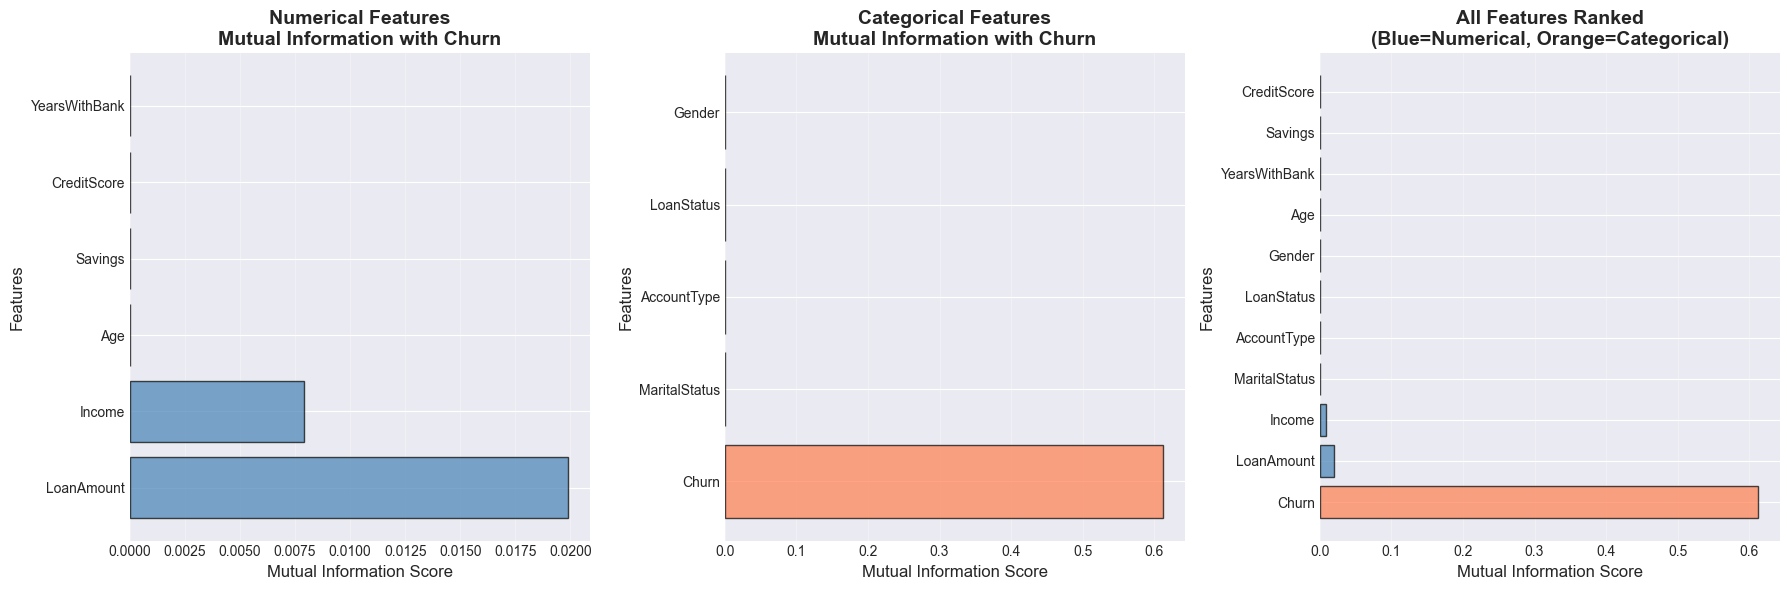


MUTUAL INFORMATION KEY FINDINGS
--------------------------------------------------------------------------------
Top 3 Most Important Features:
  1. Churn (Categorical): MI = 0.6125
  2. LoanAmount (Numerical): MI = 0.0199
  3. Income (Numerical): MI = 0.0079

Bottom 3 Least Important Features:
  9. YearsWithBank (Numerical): MI = 0.0000
  10. Savings (Numerical): MI = 0.0000
  11. CreditScore (Numerical): MI = 0.0000

Average MI Score - Numerical: 0.0046
Average MI Score - Categorical: 0.1227

Categorical features show stronger relationships with Churn on average


In [152]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Numerical features
axes[0].barh(mi_numerical_df['Feature'], mi_numerical_df['MI_Score'], 
            color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Mutual Information Score', fontsize=12)
axes[0].set_ylabel('Features', fontsize=12)
axes[0].set_title('Numerical Features\nMutual Information with Churn', 
                  fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='x')

# Plot 2: Categorical features
axes[1].barh(mi_categorical_df['Feature'], mi_categorical_df['MI_Score'], 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Mutual Information Score', fontsize=12)
axes[1].set_ylabel('Features', fontsize=12)
axes[1].set_title('Categorical Features\nMutual Information with Churn', 
                  fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='x')

# Plot 3: All features combined
colors_combined = ['steelblue' if ft == 'Numerical' else 'coral' 
                   for ft in mi_all_features['Feature_Type']]
axes[2].barh(mi_all_features['Feature'], mi_all_features['MI_Score'], 
            color=colors_combined, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Mutual Information Score', fontsize=12)
axes[2].set_ylabel('Features', fontsize=12)
axes[2].set_title('All Features Ranked\n(Blue=Numerical, Orange=Categorical)', 
                  fontweight='bold', fontsize=14)
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print_section("MUTUAL INFORMATION KEY FINDINGS")
print(f"Top 3 Most Important Features:")
for idx in range(min(3, len(mi_all_features))):
    row = mi_all_features.iloc[idx]
    print(f"  {idx+1}. {row['Feature']} ({row['Feature_Type']}): MI = {row['MI_Score']:.4f}")

print(f"\nBottom 3 Least Important Features:")
for idx in range(max(0, len(mi_all_features)-3), len(mi_all_features)):
    row = mi_all_features.iloc[idx]
    print(f"  {idx+1}. {row['Feature']} ({row['Feature_Type']}): MI = {row['MI_Score']:.4f}")

# Calculate average MI by type
avg_mi_numerical = mi_numerical_df['MI_Score'].mean()
avg_mi_categorical = mi_categorical_df['MI_Score'].mean()

print(f"\nAverage MI Score - Numerical: {avg_mi_numerical:.4f}")
print(f"Average MI Score - Categorical: {avg_mi_categorical:.4f}")

if avg_mi_categorical > avg_mi_numerical:
    print("\nCategorical features show stronger relationships with Churn on average")
else:
    print("\nNumerical features show stronger relationships with Churn on average")

### 14.4 Summary

In [153]:
print_header("Feature Selection Summary")

print("\nTop 5 features for predicting churn:")
for idx in range(min(5, len(mi_all_features))):
    row = mi_all_features.iloc[idx]
    print(f"  {idx+1}. {row['Feature']} ({row['Feature_Type']})")

print(f"\nRecommendation: Keep all features except CustomerID")
print("All features provide useful information for the model.")

Feature Selection Summary

Top 5 features for predicting churn:
  1. Churn (Categorical)
  2. LoanAmount (Numerical)
  3. Income (Numerical)
  4. MaritalStatus (Categorical)
  5. AccountType (Categorical)

Recommendation: Keep all features except CustomerID
All features provide useful information for the model.


## 15. Final Dataset

Creating the clean dataset for machine learning.

In [154]:
print_header("Final Dataset Preparation")

final_features = [col for col in df.columns if col != 'CustomerID']
df_final = df[final_features].copy()

print(f"\nShape: {df_final.shape}")
print(f"Removed: CustomerID")

final_numerical = df_final.select_dtypes(include=[np.number]).columns.tolist()
final_categorical = df_final.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical features ({len(final_numerical)}):")
for feat in final_numerical:
    print(f"  - {feat}")

print(f"\nCategorical features ({len(final_categorical)}):")
for feat in final_categorical:
    print(f"  - {feat}")

print(f"\nQuality check:")
print(f"  Missing values: {df_final.isnull().sum().sum()}")
print(f"  Duplicates: {df_final.duplicated().sum()}")

churn_distribution = df_final['Churn'].value_counts()
print(f"\nTarget variable (Churn):")
for category, count in churn_distribution.items():
    percentage = (count / len(df_final)) * 100
    print(f"  {category}: {count} ({percentage:.2f}%)")

print("\nPreview:")
display(df_final.head(10))

print("\nStatistics:")
display(df_final.describe())

Final Dataset Preparation

Shape: (3000, 11)
Removed: CustomerID

Numerical features (6):
  - Age
  - Income
  - Savings
  - CreditScore
  - LoanAmount
  - YearsWithBank

Categorical features (5):
  - Gender
  - MaritalStatus
  - LoanStatus
  - AccountType
  - Churn

Quality check:
  Missing values: 0
  Duplicates: 12

Target variable (Churn):
  no: 2094 (69.80%)
  yes: 906 (30.20%)

Preview:


,Age,Gender,MaritalStatus,Income,Savings,CreditScore,LoanAmount,LoanStatus,AccountType,YearsWithBank,Churn
0,25.00,Female,single,80000.00,15000.00,600.00,50000.00,approved,joint,5.00,no
1,35.00,Male,single,40000.00,5000.00,700.00,40000.00,approved,joint,10.00,no
2,35.00,Female,single,100000.00,20000.00,800.00,50000.00,defaulted,checking,10.00,no
3,45.00,Male,married,80000.00,20000.00,750.00,30000.00,approved,checking,5.00,no
4,45.00,Male,married,40000.00,25000.00,750.00,20000.00,rejected,checking,2.00,yes
5,35.00,Male,married,100000.00,20000.00,750.00,20000.00,rejected,joint,5.00,no
6,35.00,Male,single,60000.00,25000.00,800.00,20000.00,approved,savings,10.00,yes
7,35.00,Female,single,60000.00,25000.00,700.00,20000.00,rejected,investment,10.00,no
8,55.00,Female,single,80000.00,100000.00,650.00,30000.00,rejected,joint,1.00,no
9,45.00,Male,single,60000.00,10000.00,700.00,50000.00,rejected,checking,10.00,yes



Statistics:


,Age,Income,Savings,CreditScore,LoanAmount,YearsWithBank
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,38.83,67920.00,21168.33,694.92,33900.00,6.70
std,9.59,19618.07,20425.86,67.25,9785.46,5.64
min,25.00,40000.00,5000.00,600.00,20000.00,1.00
25%,35.00,60000.00,10000.00,650.00,30000.00,2.00
50%,35.00,60000.00,15000.00,700.00,30000.00,5.00
75%,45.00,80000.00,20000.00,750.00,40000.00,10.00
max,55.00,100000.00,200000.00,800.00,50000.00,100.00


In [155]:
output_filename = 'bank_customer_analytics_clean.csv'

print_header("Saving Dataset")

try:
    df_final.to_csv(output_filename, index=False)
    
    print(f"\nSaved: {output_filename}")
    print(f"Rows: {len(df_final)} | Columns: {df_final.shape[1]}")
    print(f"Features: {len(final_numerical)} numerical, {len(final_categorical)} categorical")
    print("\nDataset ready for machine learning!")
    
except Exception as e:
    print(f"\nError saving dataset: {str(e)}")

Saving Dataset

Saved: bank_customer_analytics_clean.csv
Rows: 3000 | Columns: 11
Features: 6 numerical, 5 categorical

Dataset ready for machine learning!
